In [ ]:
!pip install torch scikit-learn numpy pandas scipy matplotlib umap-learn tensorflow

In [ ]:
!git clone https://github.com/ZhangLabGT/scDisInFact.git

In [ ]:
%cd scDisInFact
!pip install .

In [1]:
import sys, os
import torch
import numpy as np
import pandas as pd
from scDisInFact import scdisinfact, create_scdisinfact_dataset
from scDisInFact import utils

import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.decomposition import PCA
import scipy.sparse as sp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load the dataset
We used the simulated dataset with $2$ batches and $2$ condition types:
* groups in type 1: `ctrl`, `stim`
* groups in type 2: `healthy`, `severe`

Totally $8$ count matrices are included (Fig. 2a in the manuscript). We hold out the count matrix corresponding to condition `(ctrl, healthy, batch 0)` for testing purpose, and train scdisinfact on remaining count matrices.

Given the count matrix (list of count matrices where one may correspond to one batch), the meta_cell dataframe (list of dataframe that matches the list of count matrices), and gene names, scDisInFact create training dataset using function `scdisinfact.create_scdisinfact_dataset()`


In [2]:
counts = sp.load_npz("/content/scDisInFact/data/demo_data/counts.npz")
meta_cells = pd.read_csv("/content/scDisInFact/data/demo_data/meta_cells.csv", index_col = 0)
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
train_idx = ~test_idx

data_dict = create_scdisinfact_dataset(counts[train_idx,:], meta_cells.loc[train_idx,:], condition_key = ["condition 1", "condition 2"], batch_key = "batch")

result_dir = "demo_result/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


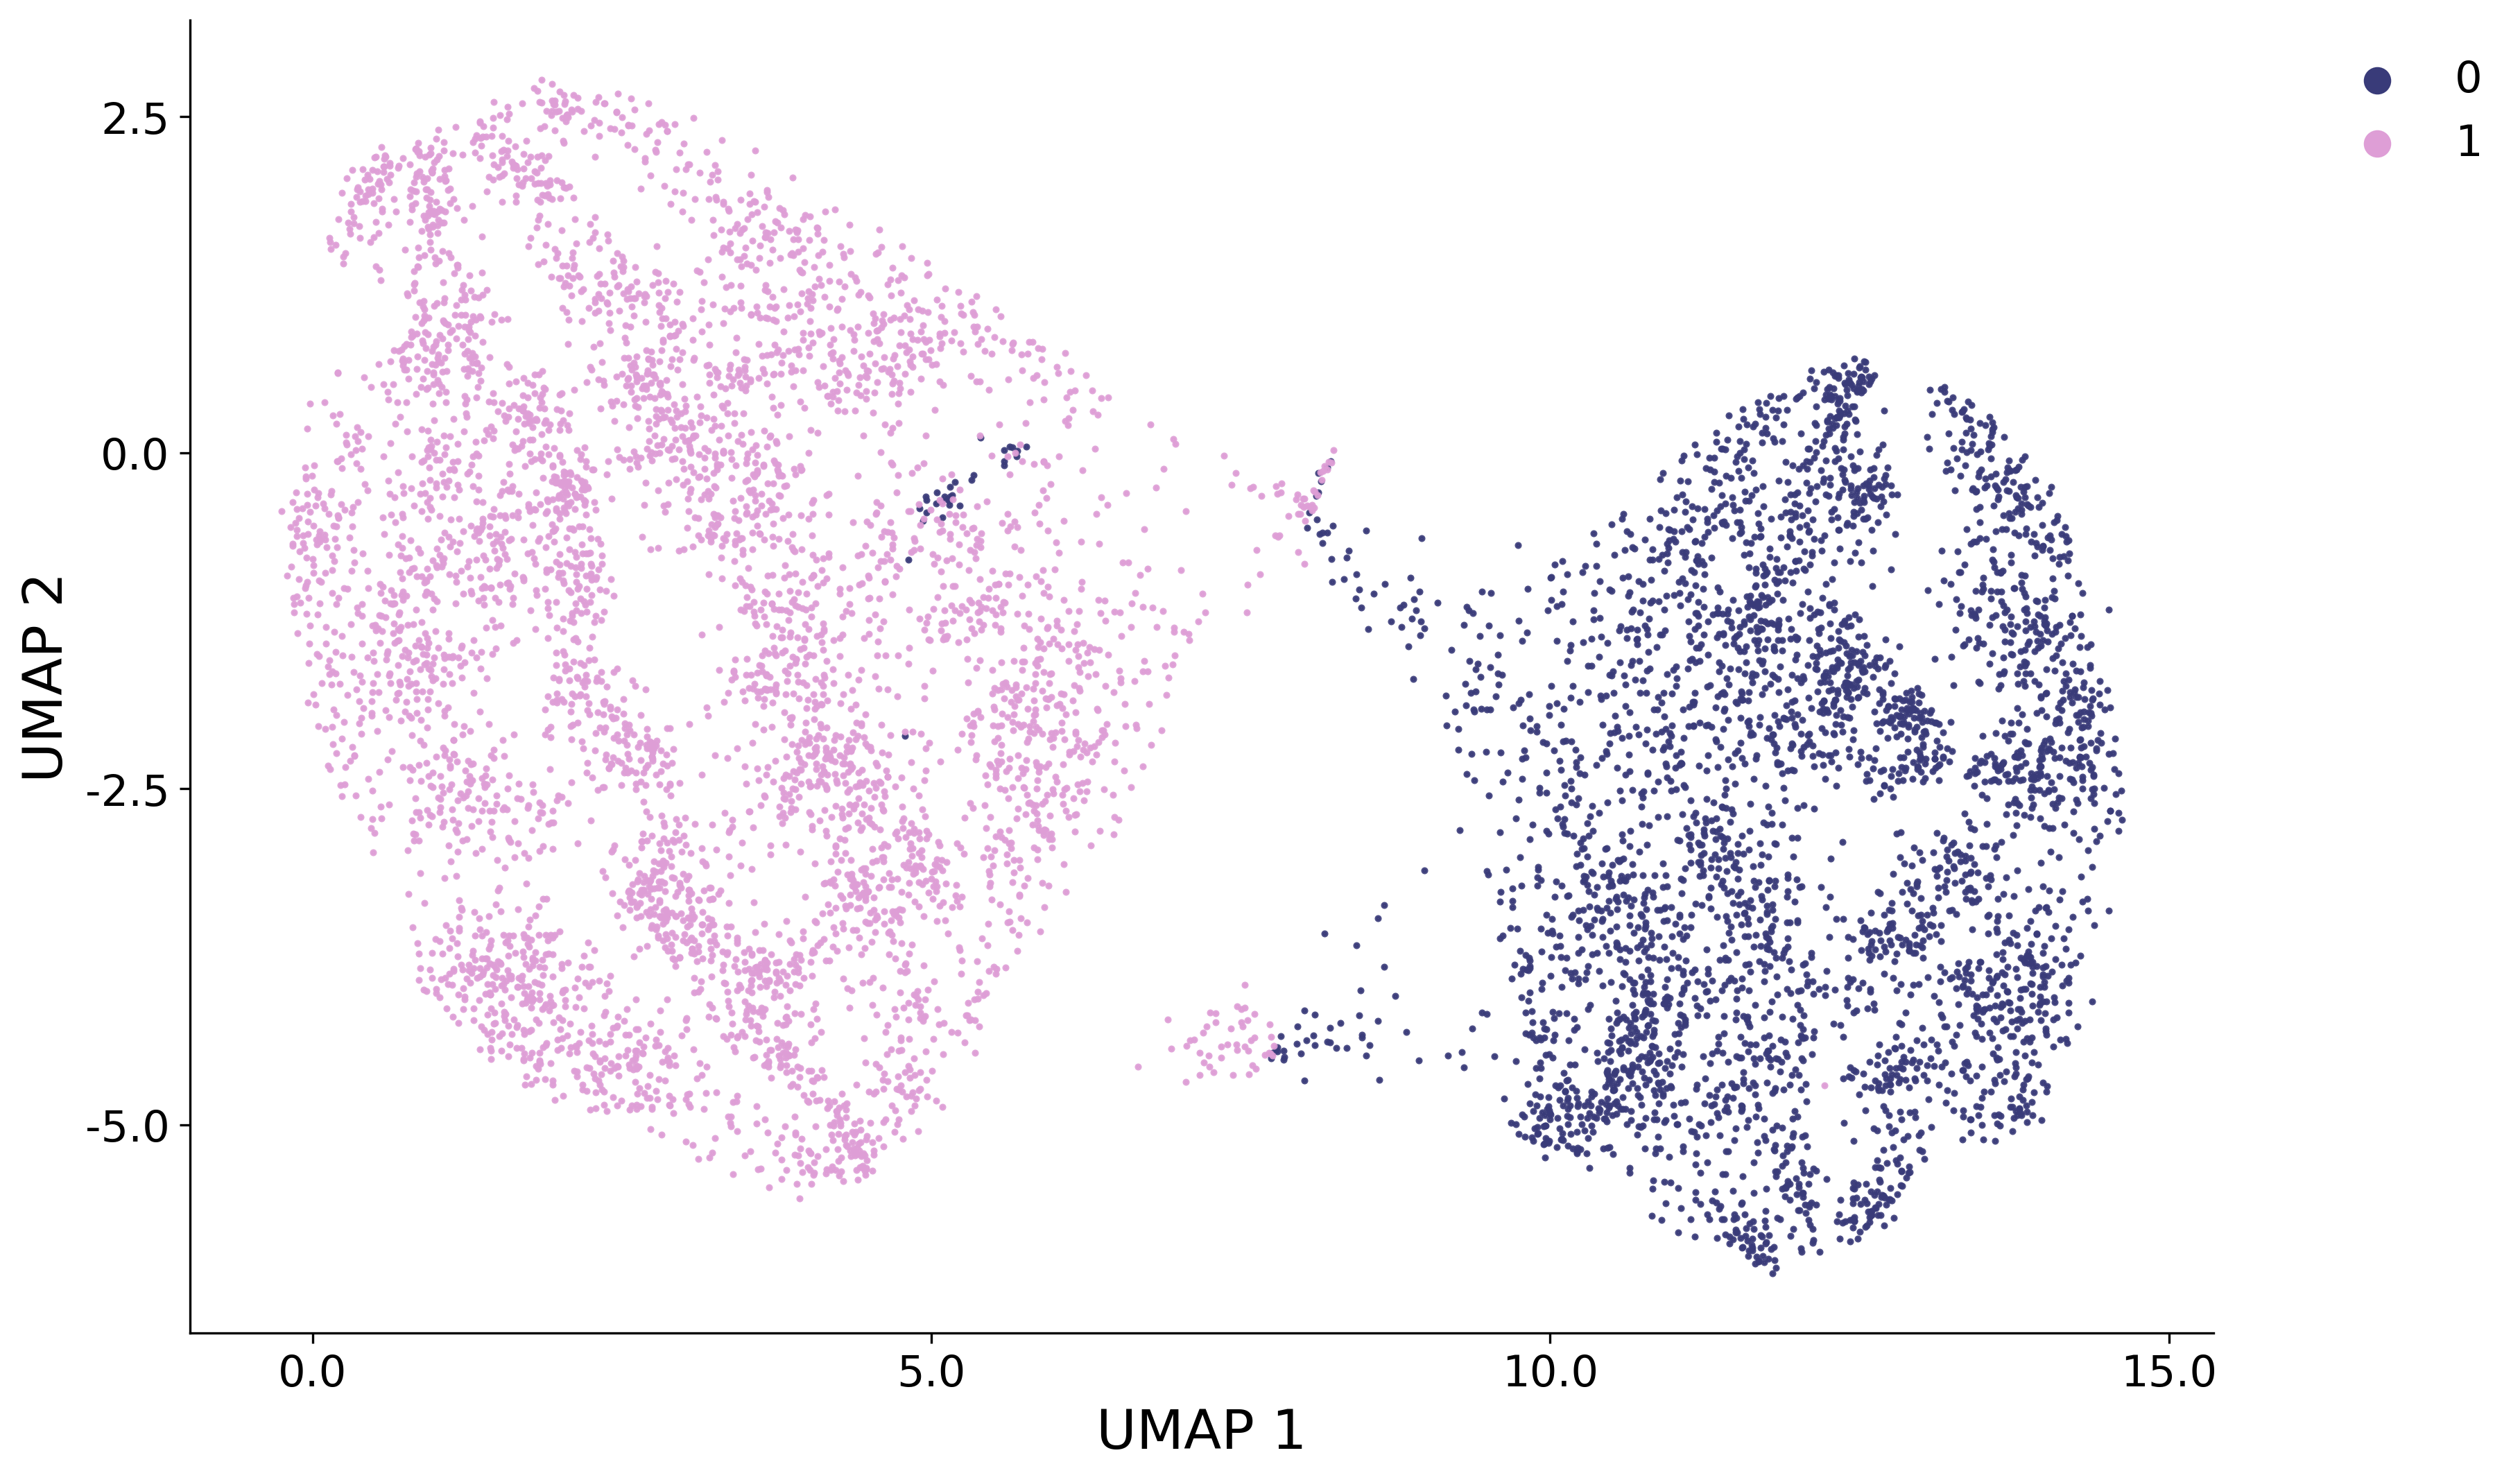

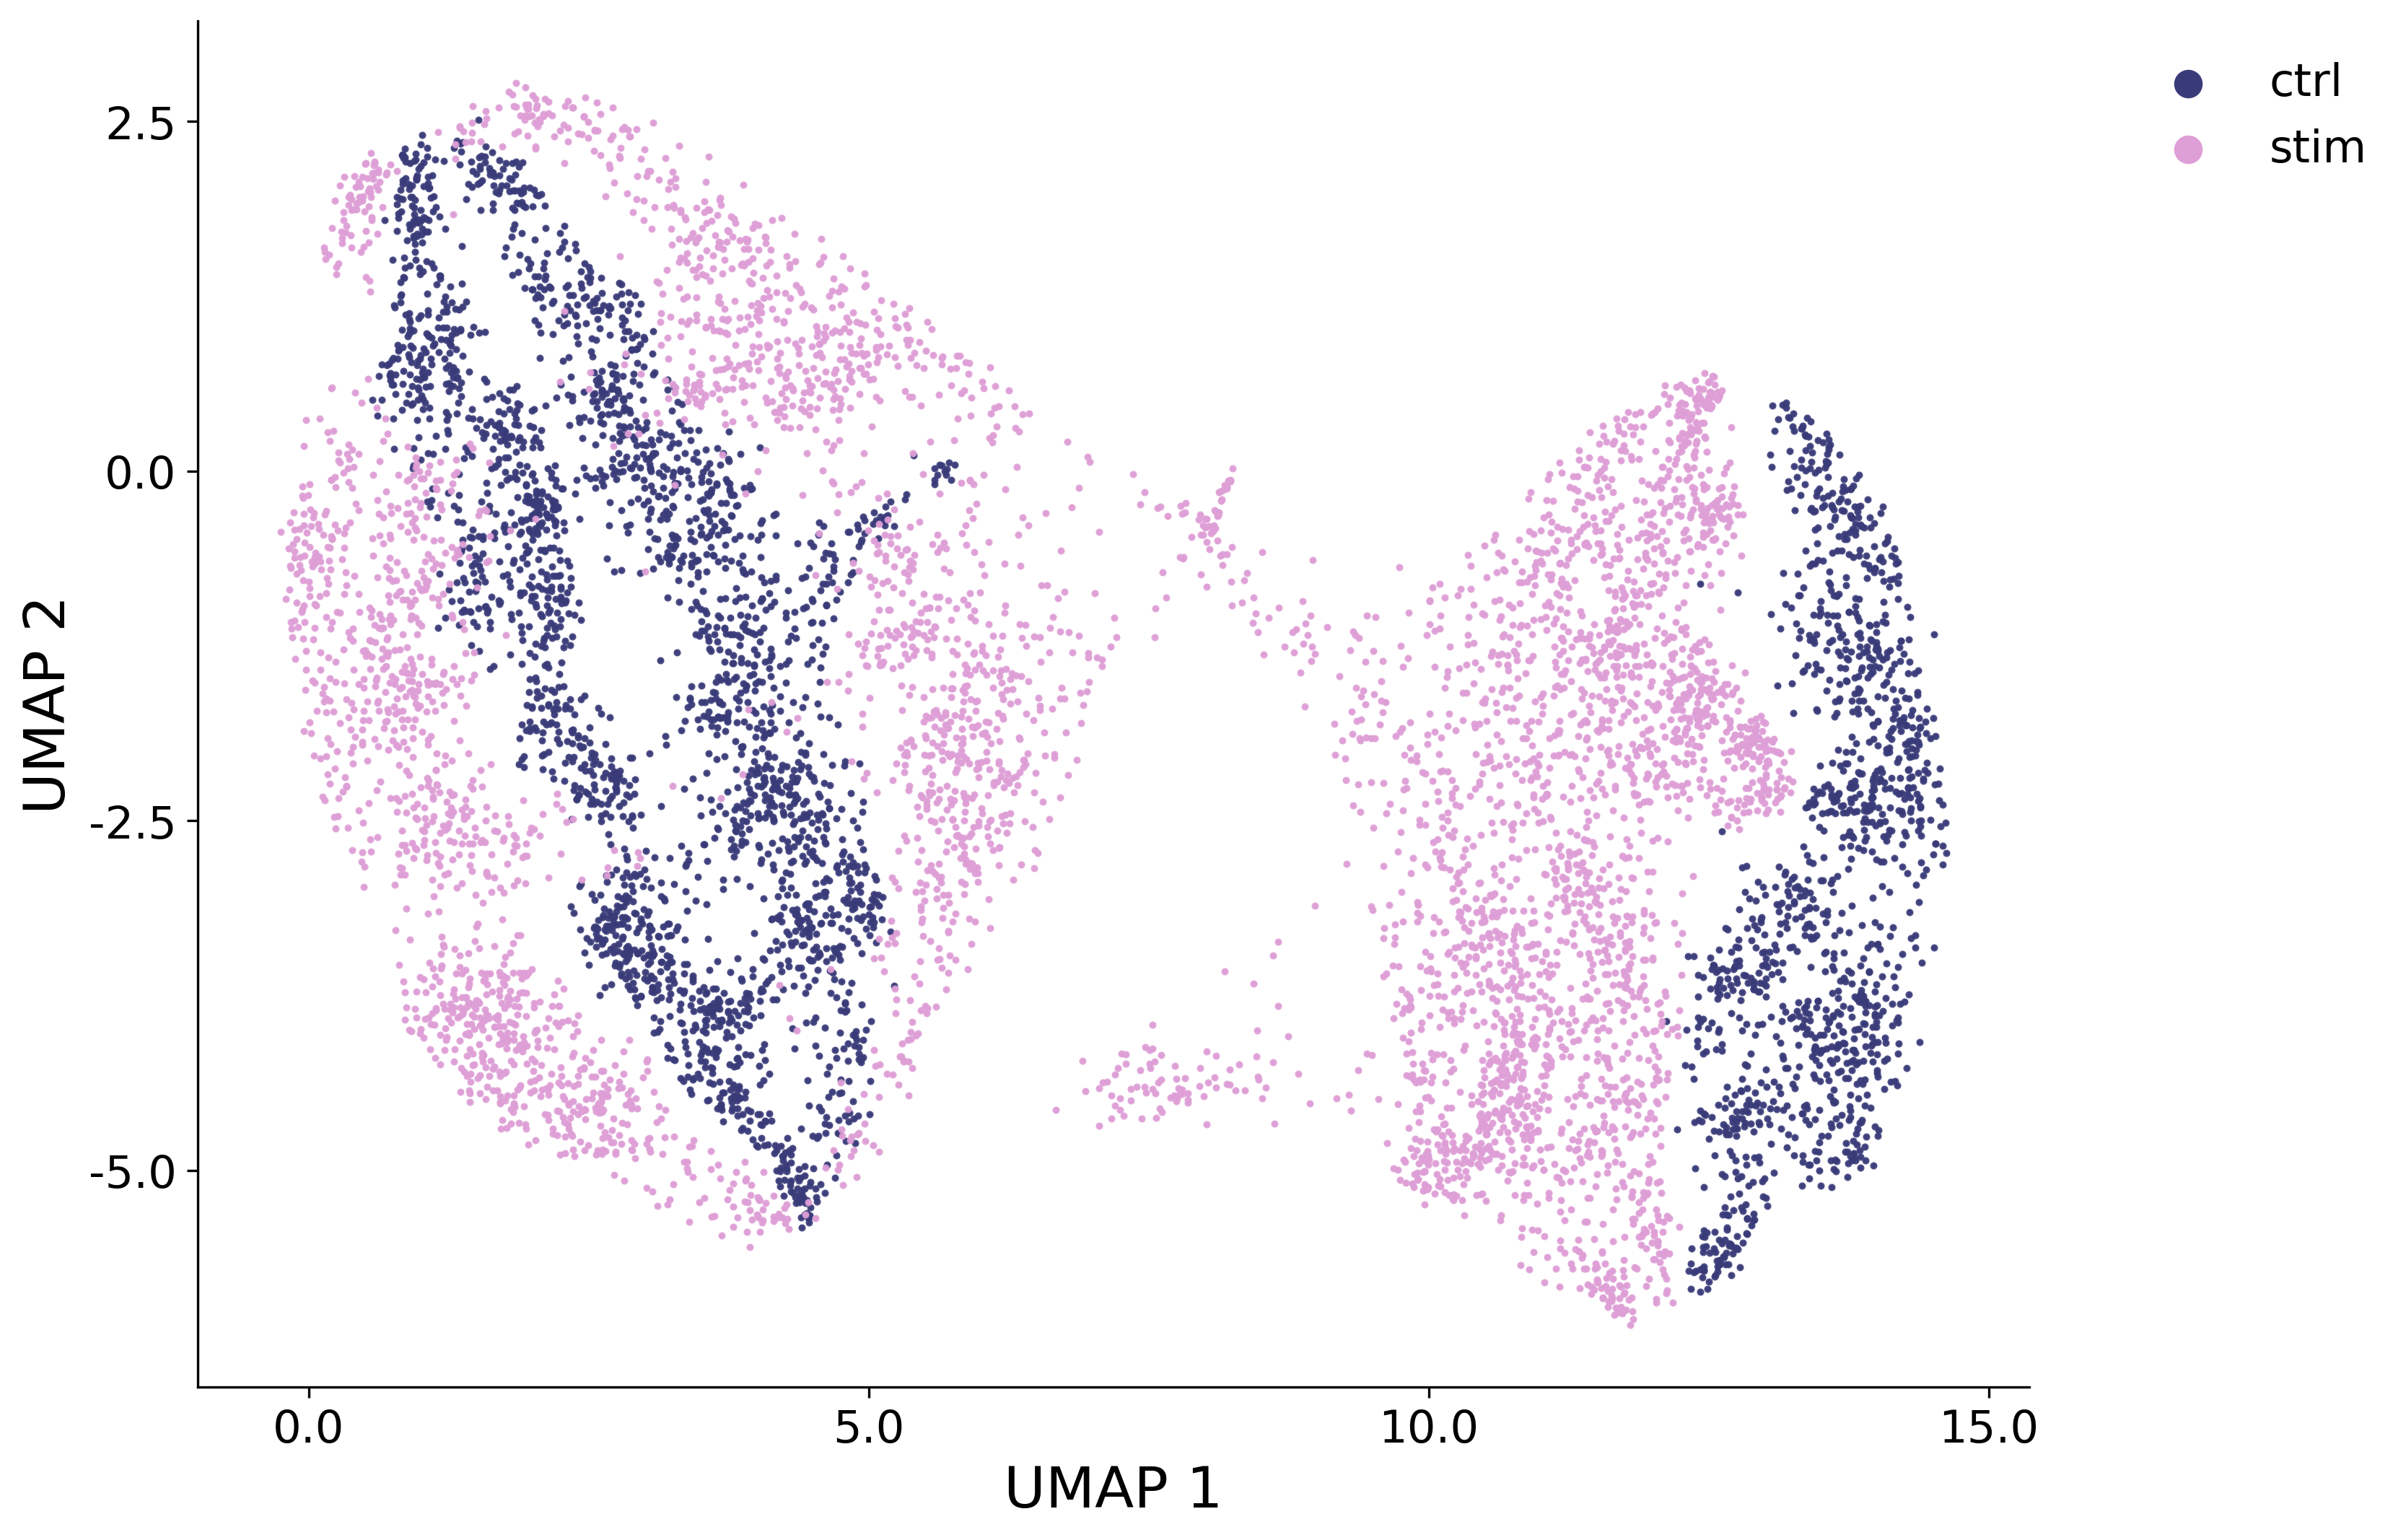

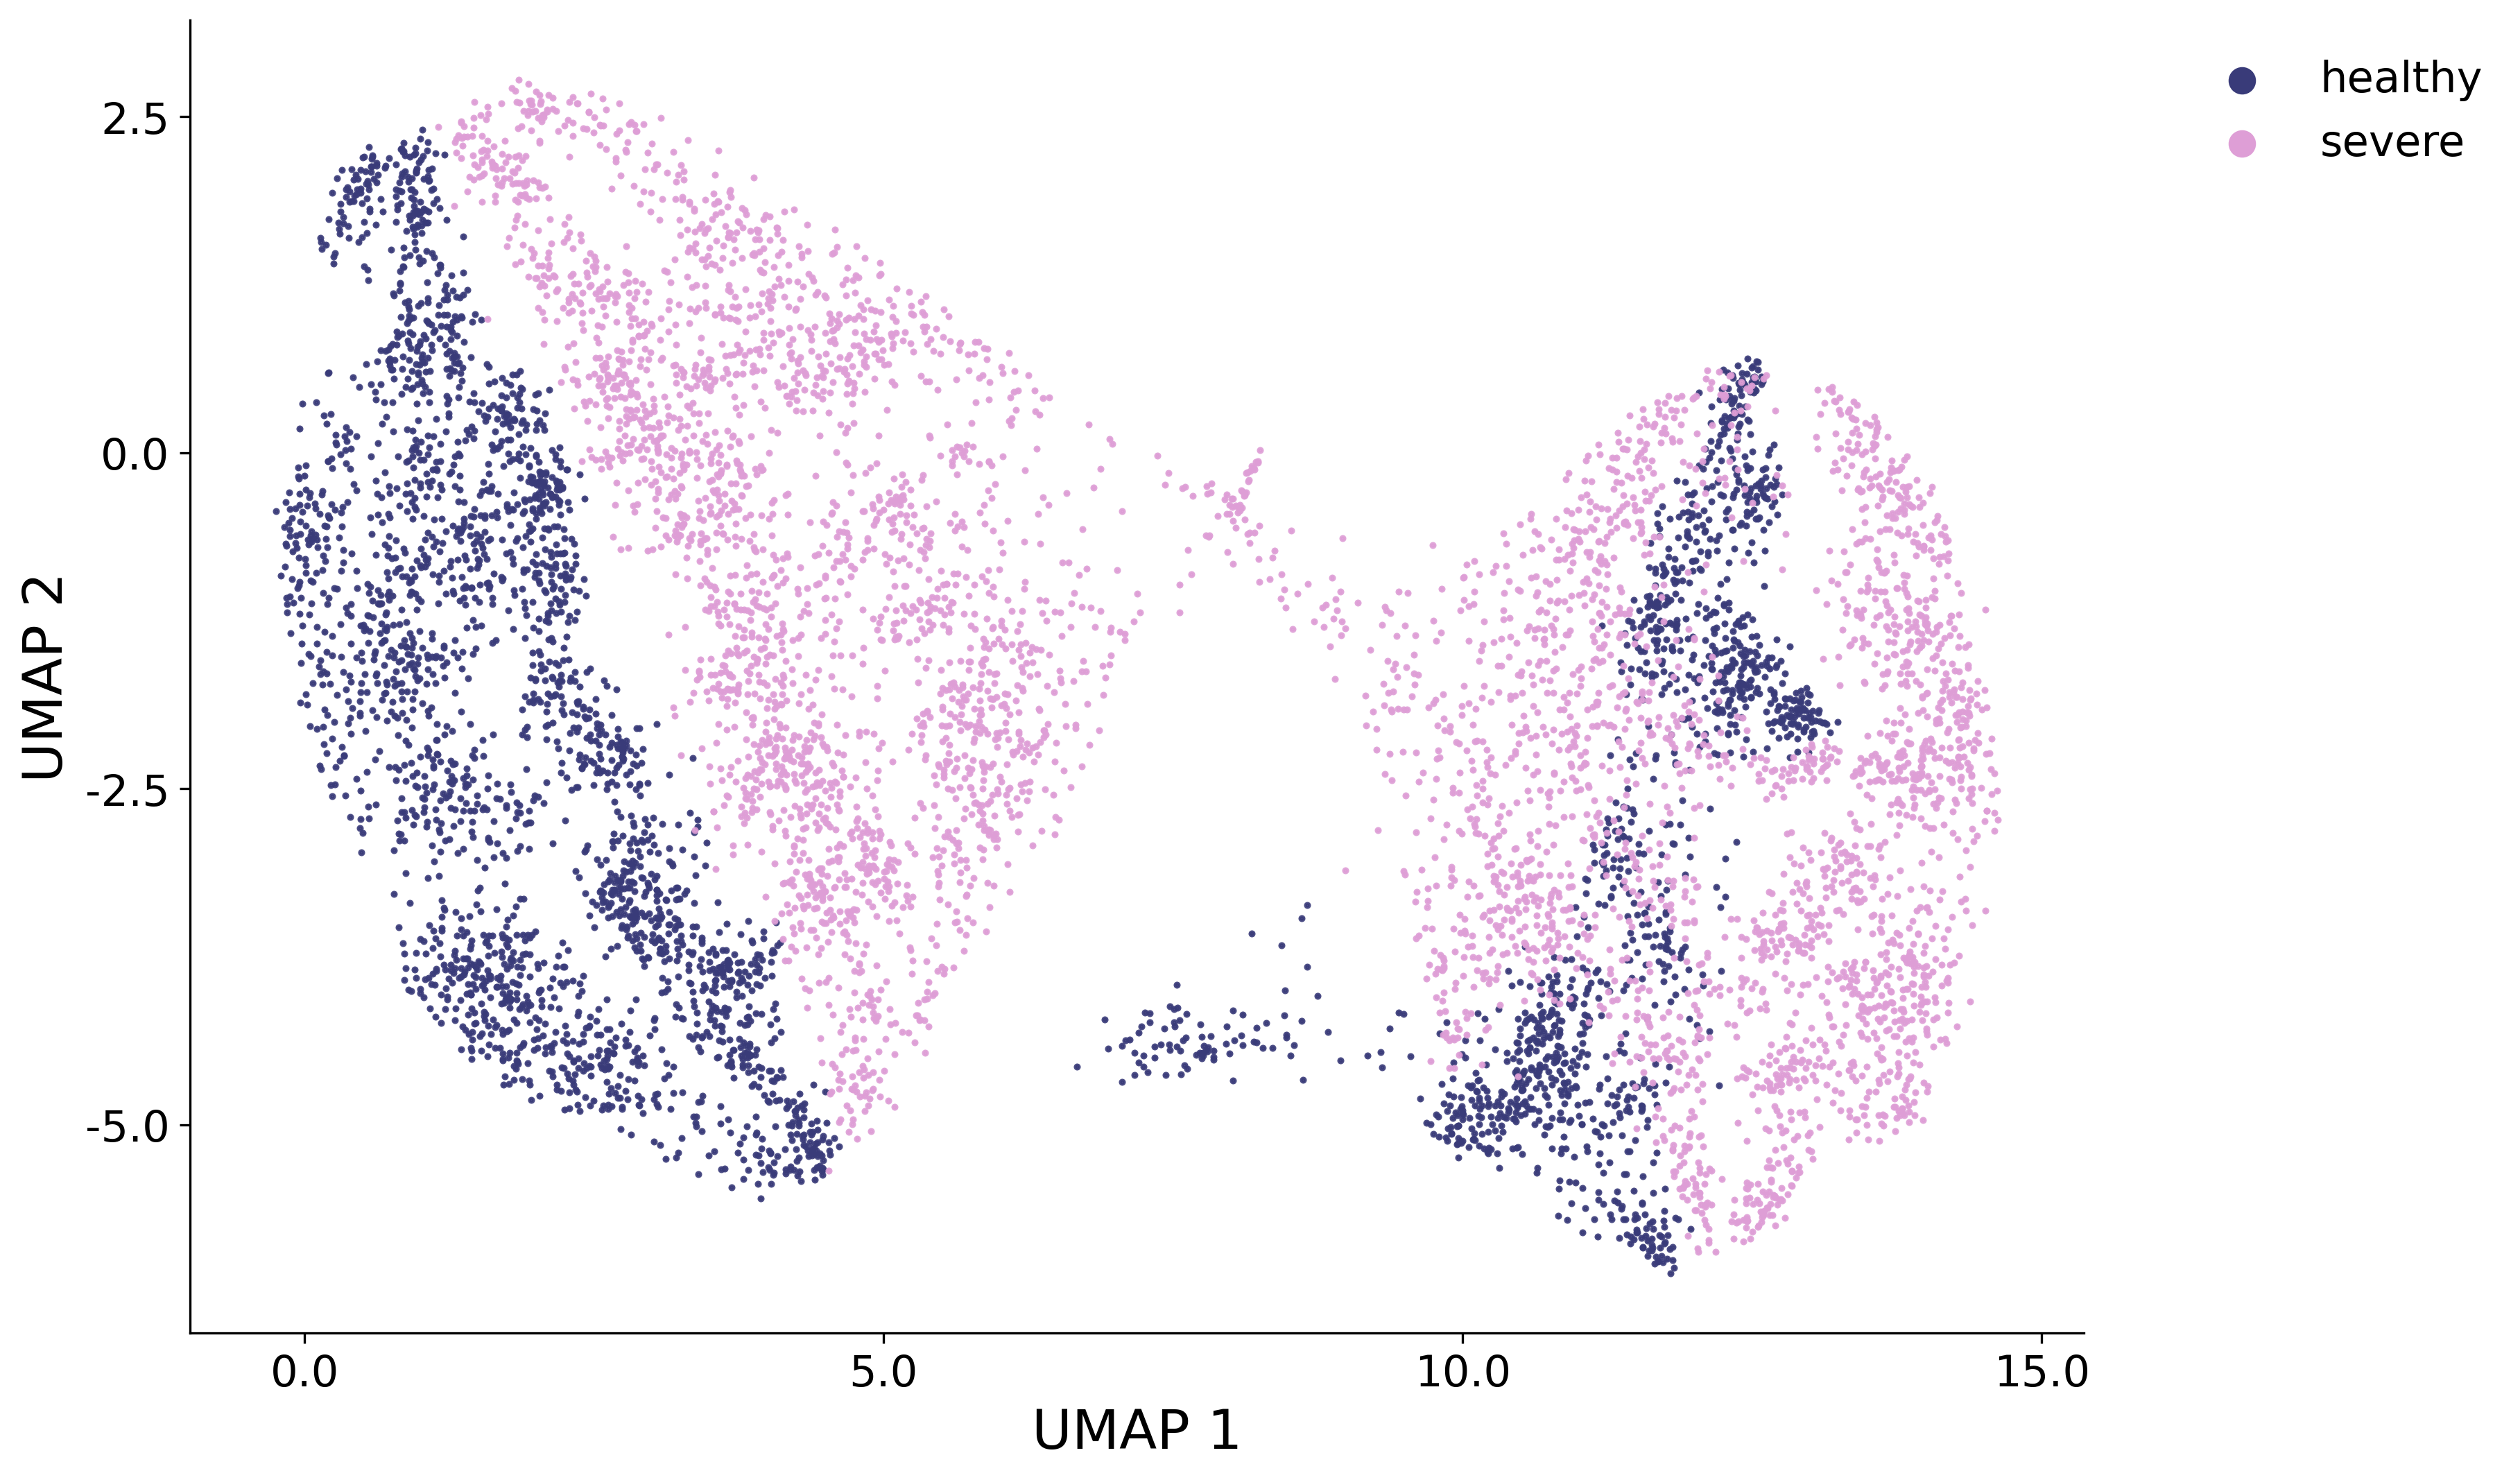

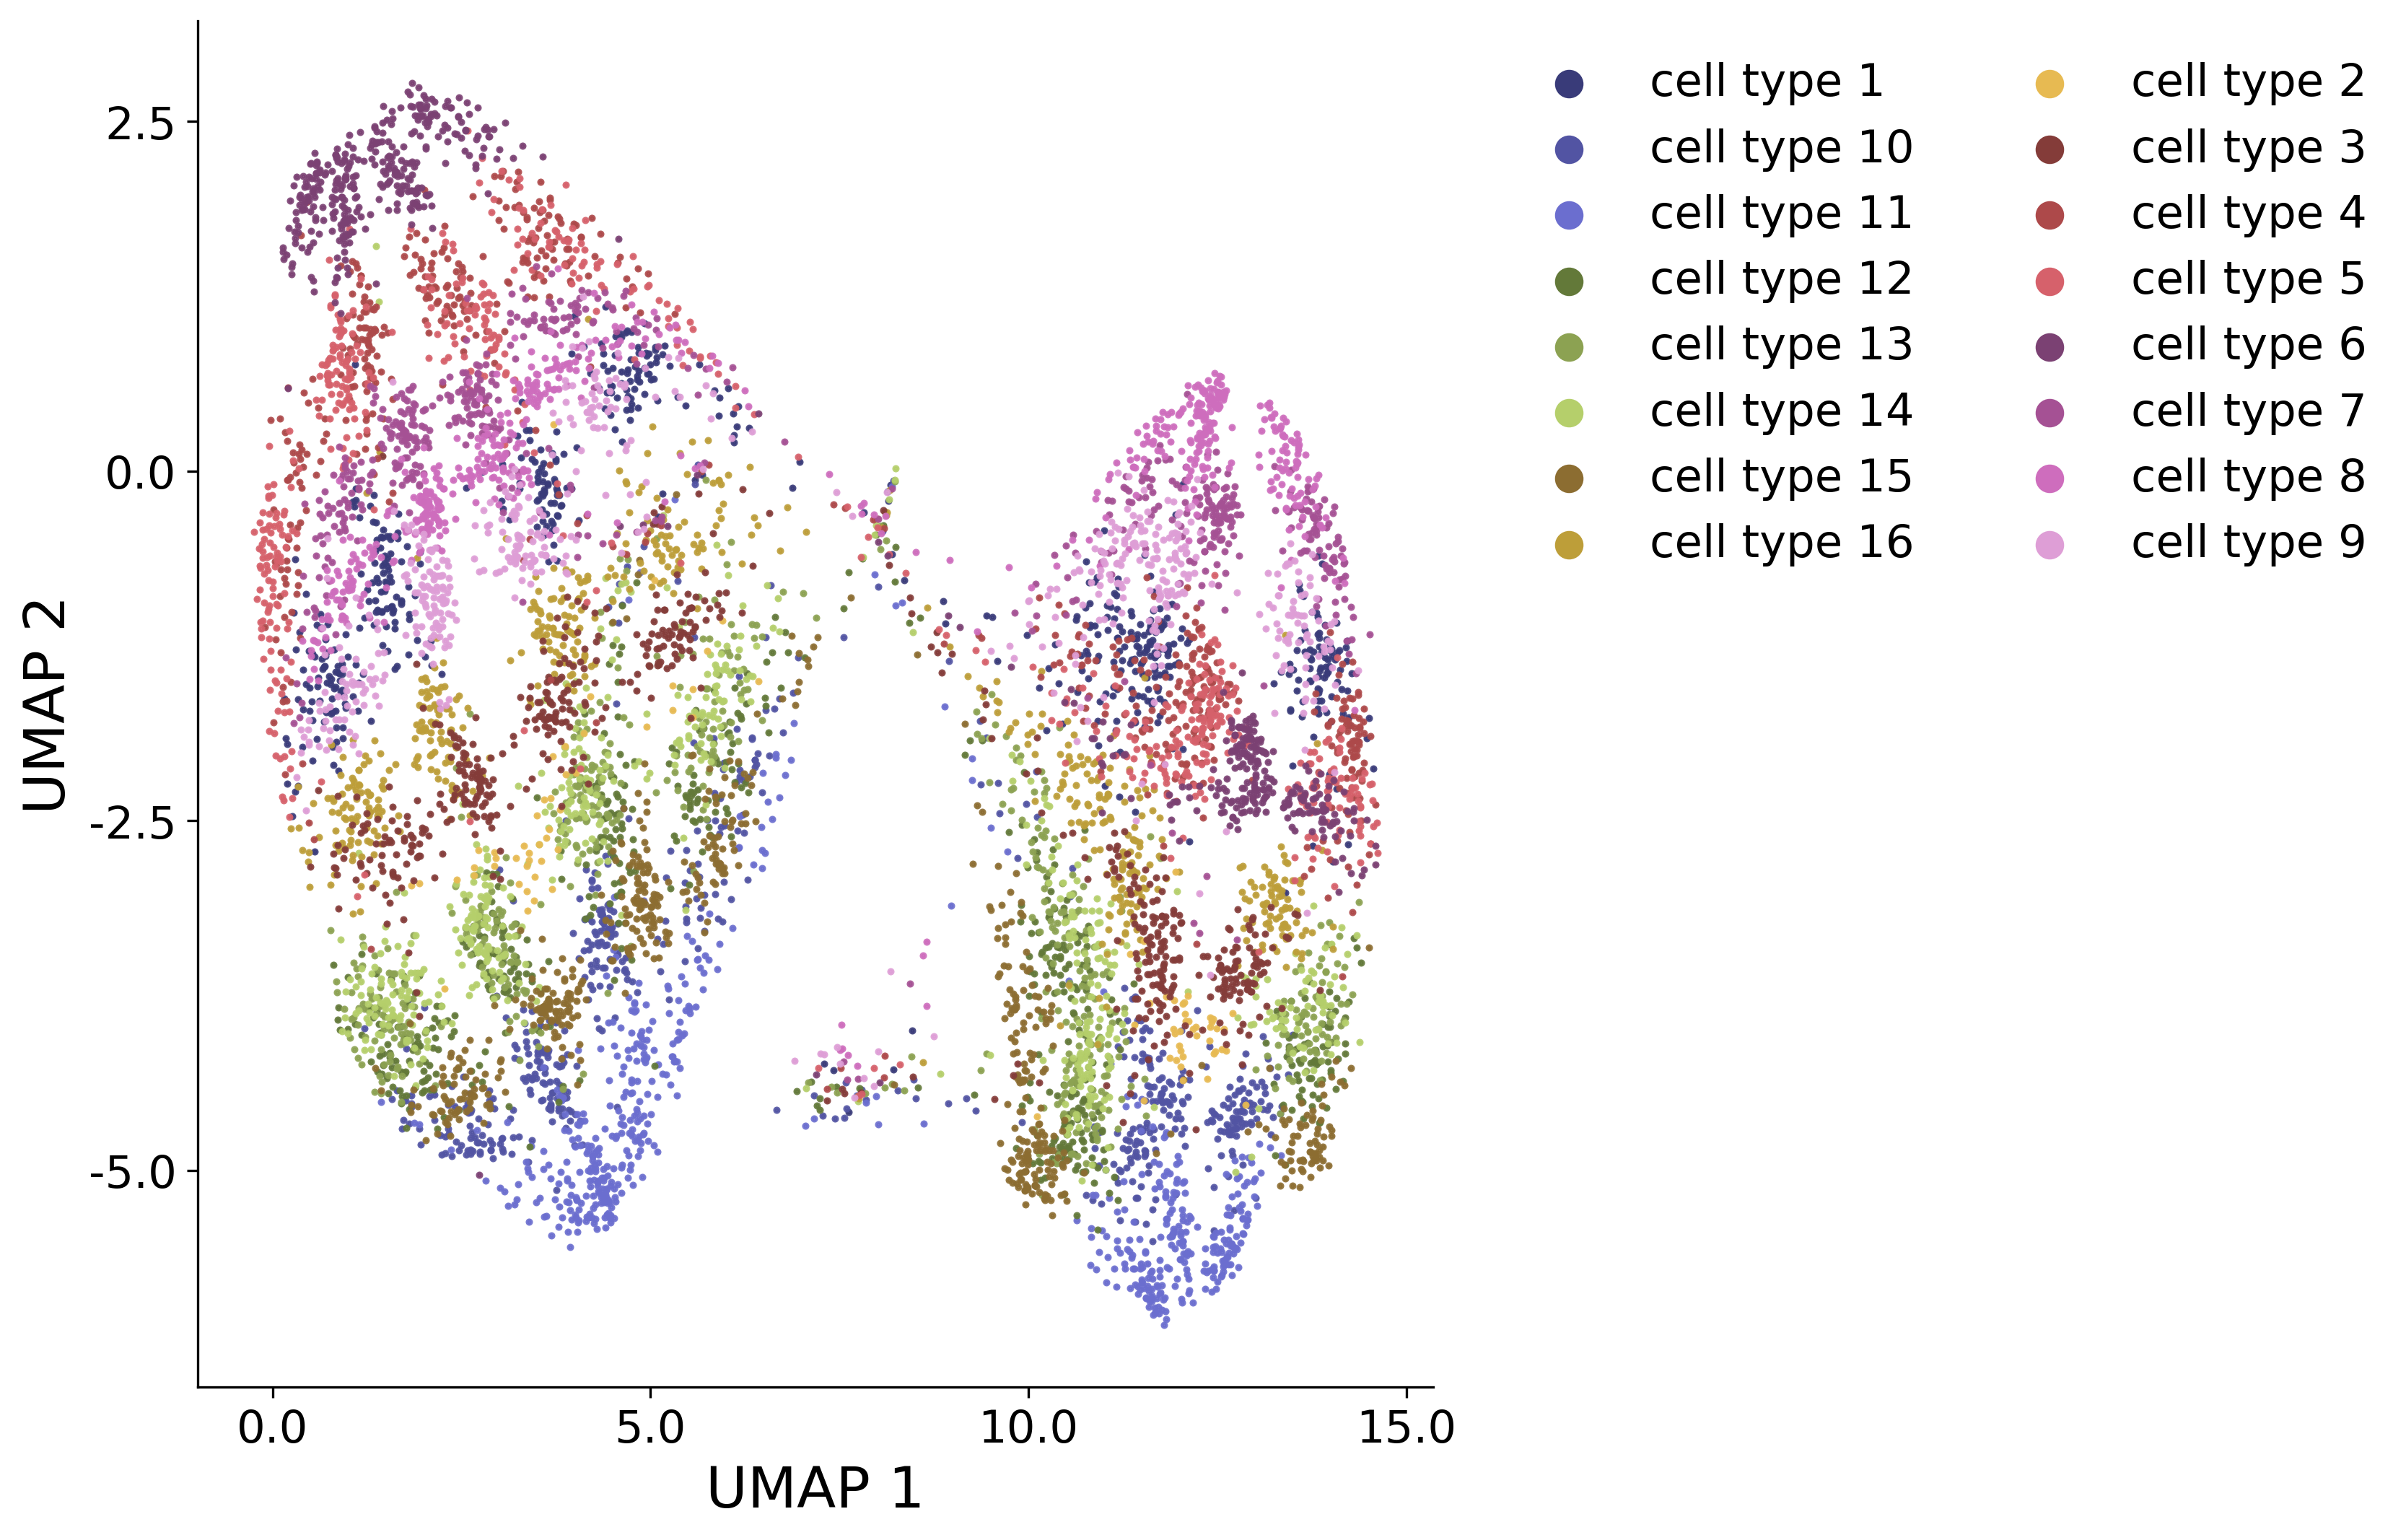

In [20]:
# Visualize the raw gene expression data
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0)

x_pca = PCA(n_components = 80).fit_transform(np.concatenate([x.counts_norm for x in data_dict["datasets"]], axis = 0))
x_umap = umap_op.fit_transform(x_pca)

utils.plot_latent(x_umap, annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "batches.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_1.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_2.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "celltypes.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)


In [21]:
batch_annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]])
batch_annos = np.where(batch_annos == 0, "batch 1", "batch 2")

import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2

def kBET(data, batch_labels, k=30, alpha=0.05):
    """
    Compute the kBET rejection rate for a given dataset.

    Parameters:
    - data: np.array of shape (n_samples, n_features), low-dimensional embeddings.
    - batch_labels: np.array of shape (n_samples,), batch annotations.
    - k: int, number of neighbors to consider.
    - alpha: float, significance level for the chi-squared test.

    Returns:
    - rejection_rate: float, proportion of samples rejecting the null hypothesis.
    """
    nn = NearestNeighbors(n_neighbors=k + 1).fit(data)
    distances, indices = nn.kneighbors(data)
    rejection_count = 0
    n_samples = data.shape[0]

    # Iterate over each point
    for i in range(n_samples):
        neighbors = batch_labels[indices[i][1:]]  # Exclude the point itself
        observed_counts = np.bincount(neighbors, minlength=np.unique(batch_labels).size)
        expected_counts = np.full_like(observed_counts, k / len(np.unique(batch_labels)))

        # Perform chi-squared test
        chi2_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)
        p_value = 1 - chi2.cdf(chi2_stat, df=len(observed_counts) - 1)
        if p_value < alpha:
            rejection_count += 1

    # Compute rejection rate
    rejection_rate = rejection_count / n_samples
    return rejection_rate

data = x_umap  # UMAP embeddings
batch_labels = np.array([0 if b == "batch 1" else 1 for b in batch_annos])  # Encode batch labels
k = 30  # Choose number of neighbors

kbet_rejection_rate = kBET(data, batch_labels, k=k)
print(f"kBET rejection rate: {kbet_rejection_rate}")


kBET rejection rate: 0.9898367020669179


## Training scDisInFact
We use the default hyper-parameter setting

In [4]:
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 2, 2]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4
lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr,
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class,
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
model.train()
losses = model.train_model(nepochs = nepochs, recon_loss = "NB")
torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location = device))
_ = model.eval()


Epoch 0, Validating Loss: 3.6535
	 loss reconstruction: 2.18248
	 loss kl comm: 1.66012
	 loss kl diff: 2.66114
	 loss mmd common: 2.60707
	 loss mmd diff: 15.47394
	 loss classification: 0.90530
	 loss group lasso diff: 0.53727
GPU memory usage: 0.000000MB
Epoch 10, Validating Loss: 2.1298
	 loss reconstruction: 1.75344
	 loss kl comm: 17.09795
	 loss kl diff: 8.90034
	 loss mmd common: 5.79834
	 loss mmd diff: 3.48649
	 loss classification: 0.08842
	 loss group lasso diff: 0.19786
GPU memory usage: 0.000000MB
Epoch 20, Validating Loss: 1.9919
	 loss reconstruction: 1.71622
	 loss kl comm: 26.45843
	 loss kl diff: 7.22128
	 loss mmd common: 5.28608
	 loss mmd diff: 2.44683
	 loss classification: 0.04873
	 loss group lasso diff: 0.15374
GPU memory usage: 0.000000MB
Epoch 30, Validating Loss: 1.9310
	 loss reconstruction: 1.69560
	 loss kl comm: 32.52485
	 loss kl diff: 6.11806
	 loss mmd common: 4.53970
	 loss mmd diff: 2.29383
	 loss classification: 0.03824
	 loss group lasso diff: 0.

<ipython-input-4-1b7a199cd72a>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{l

## Visualize shared-bio and unshared-bio factors
After training the model, we extracted the shared-bio and unshared-bio factors from the encoder output.

To conduct forward pass on a test dataset, two functions are needed:
* `model.inference()`: infer the latent factor from the gene expression data (encoder)
* `model.generate()`: generate the gene expression data from the latent factors (decoder)

In [5]:
# one forward pass
z_cs = []
z_ds = []
zs = []

for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = model.inference(counts = dataset.counts_norm.to(model.device), batch_ids = dataset.batch_id[:,None].to(model.device), print_stat = True)
        # pass through the decoder
        dict_gen = model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        z = torch.cat([z_c] + z_d, dim = 1)
        mu = dict_gen["mu"]
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())
        zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis = 1))



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


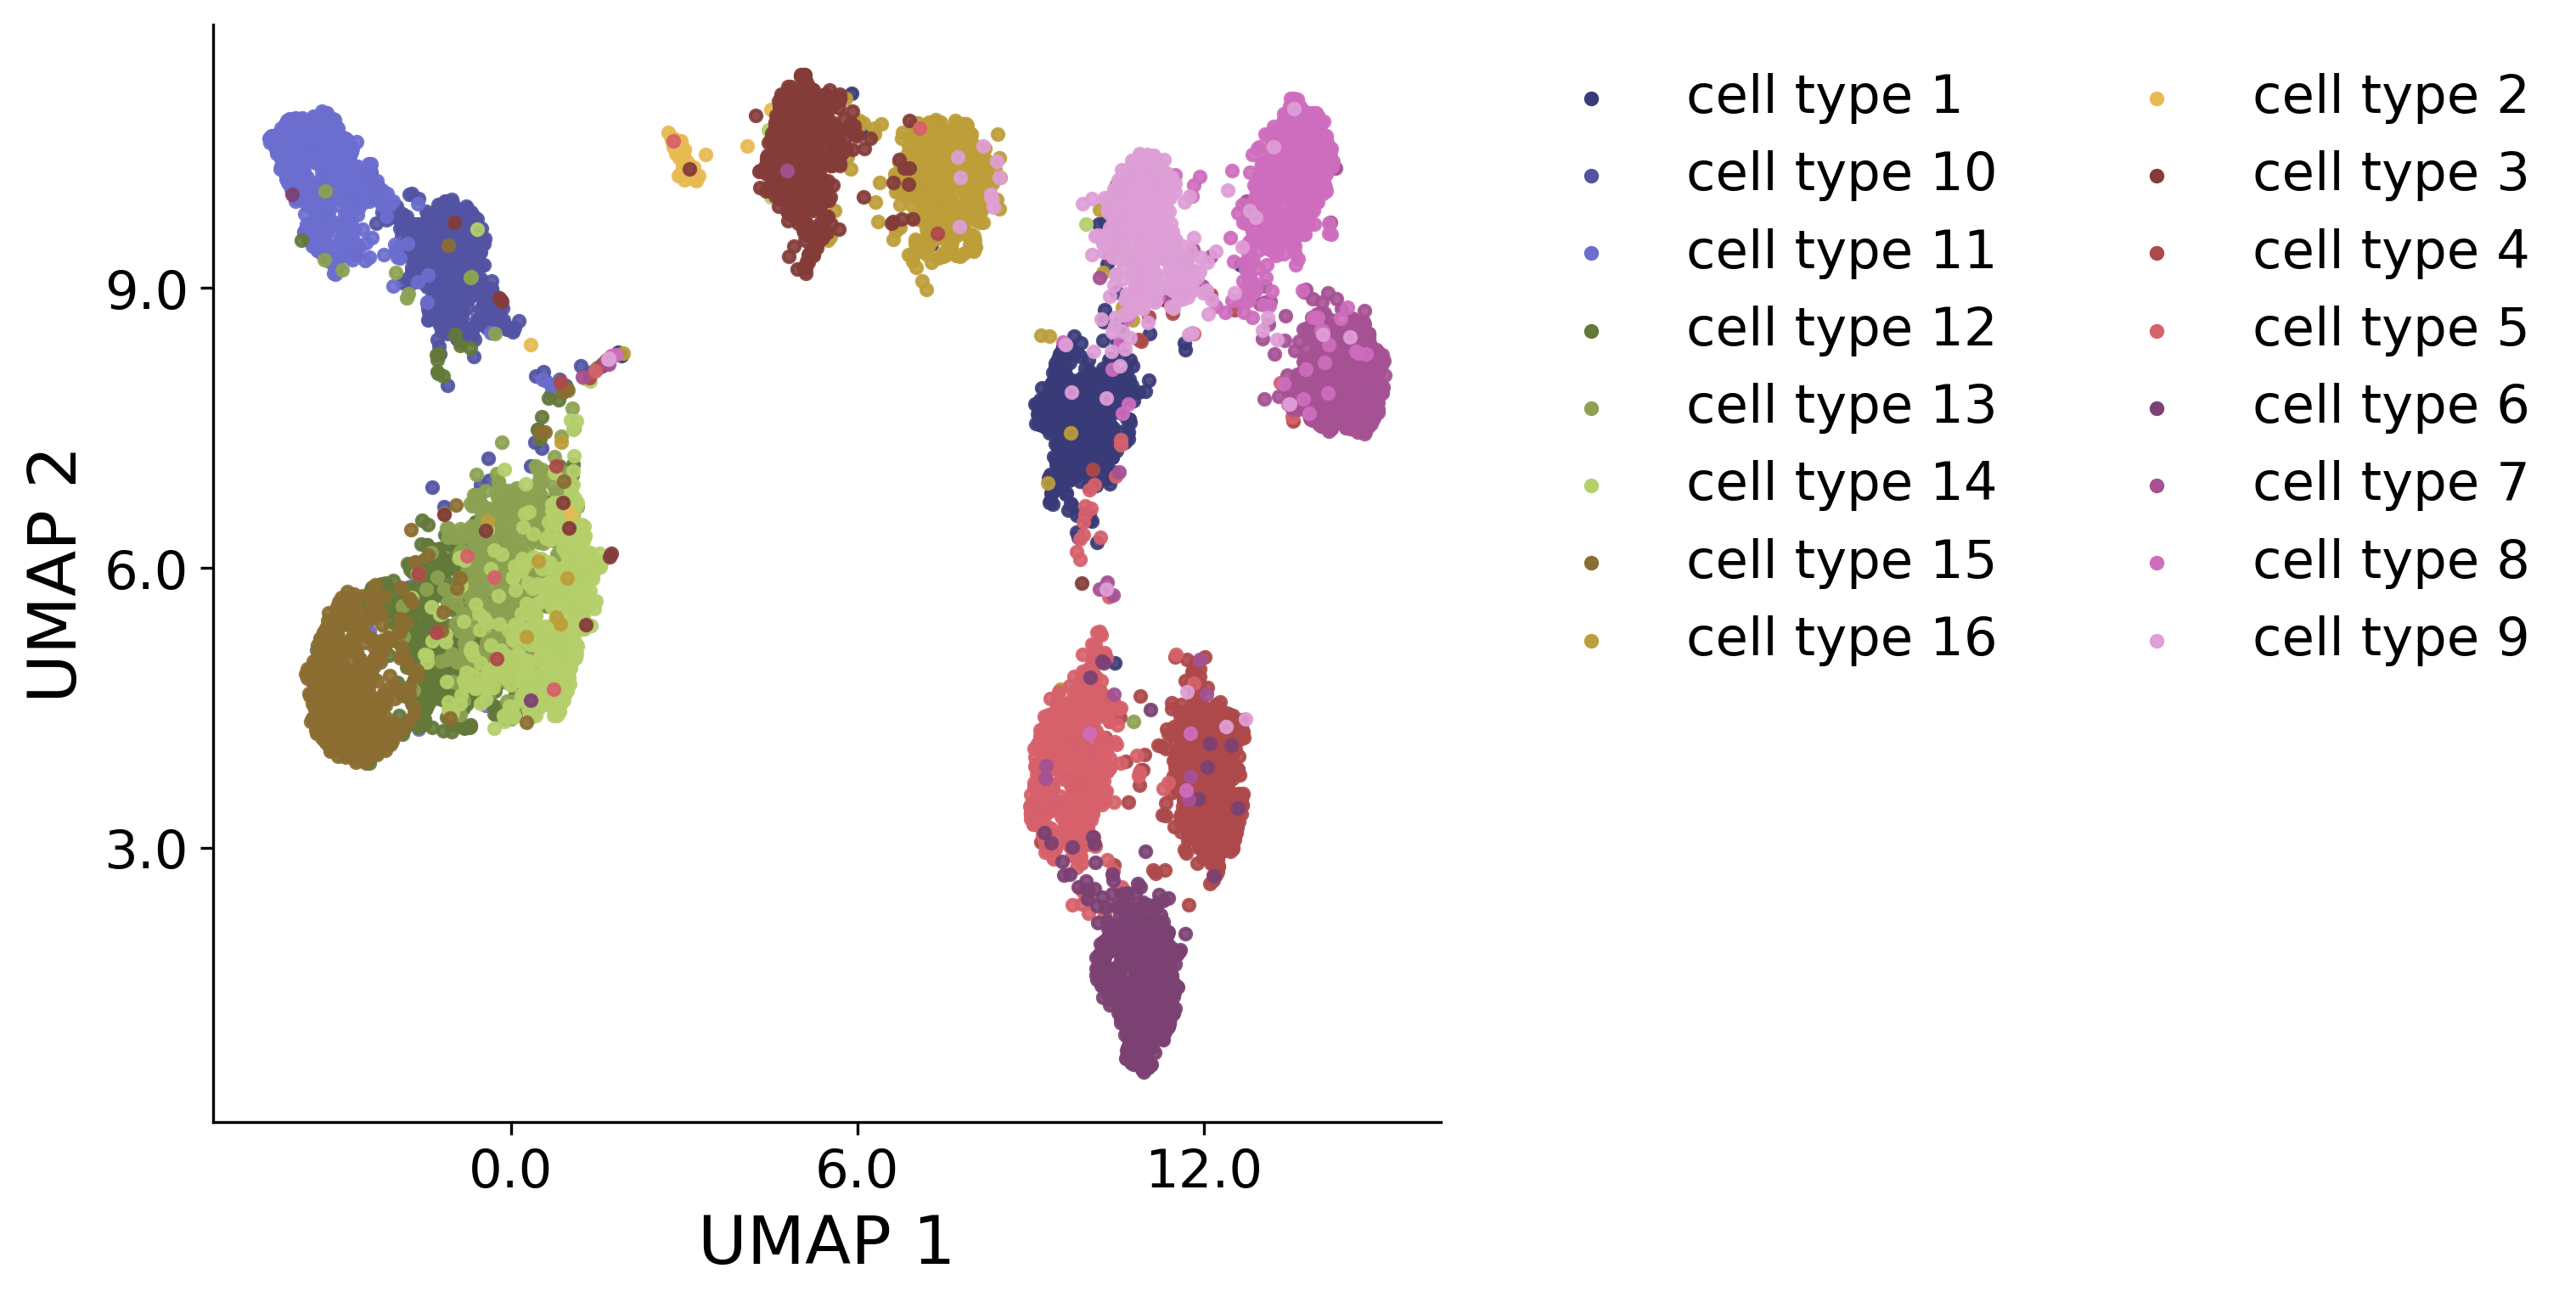

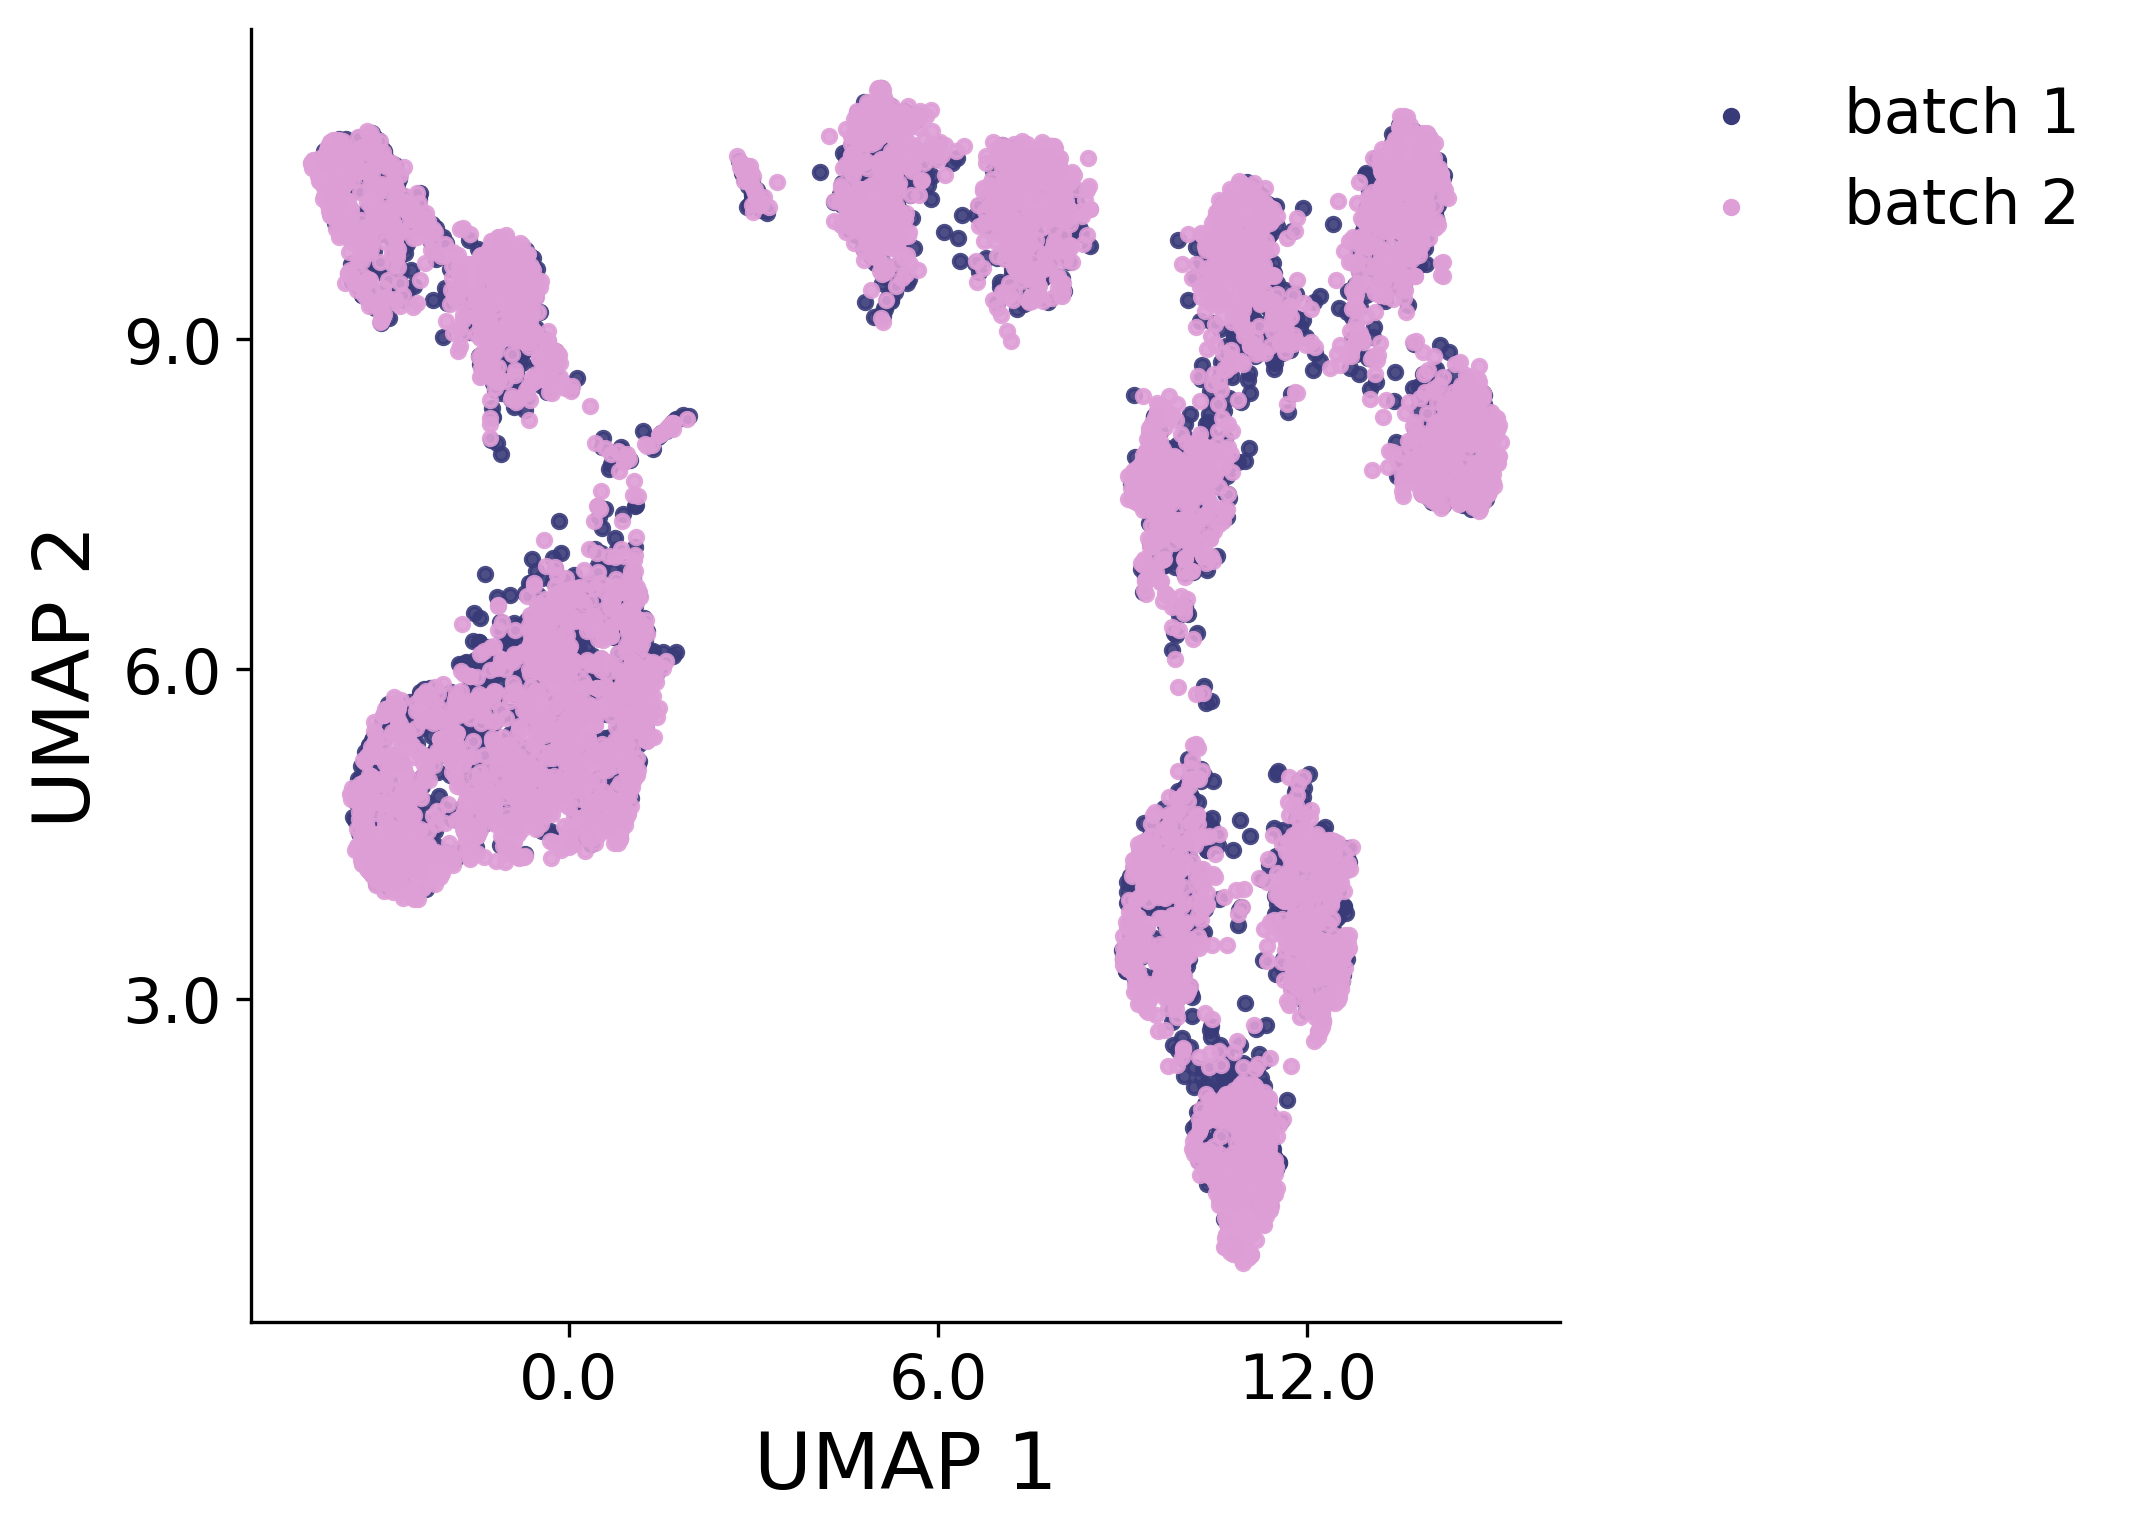

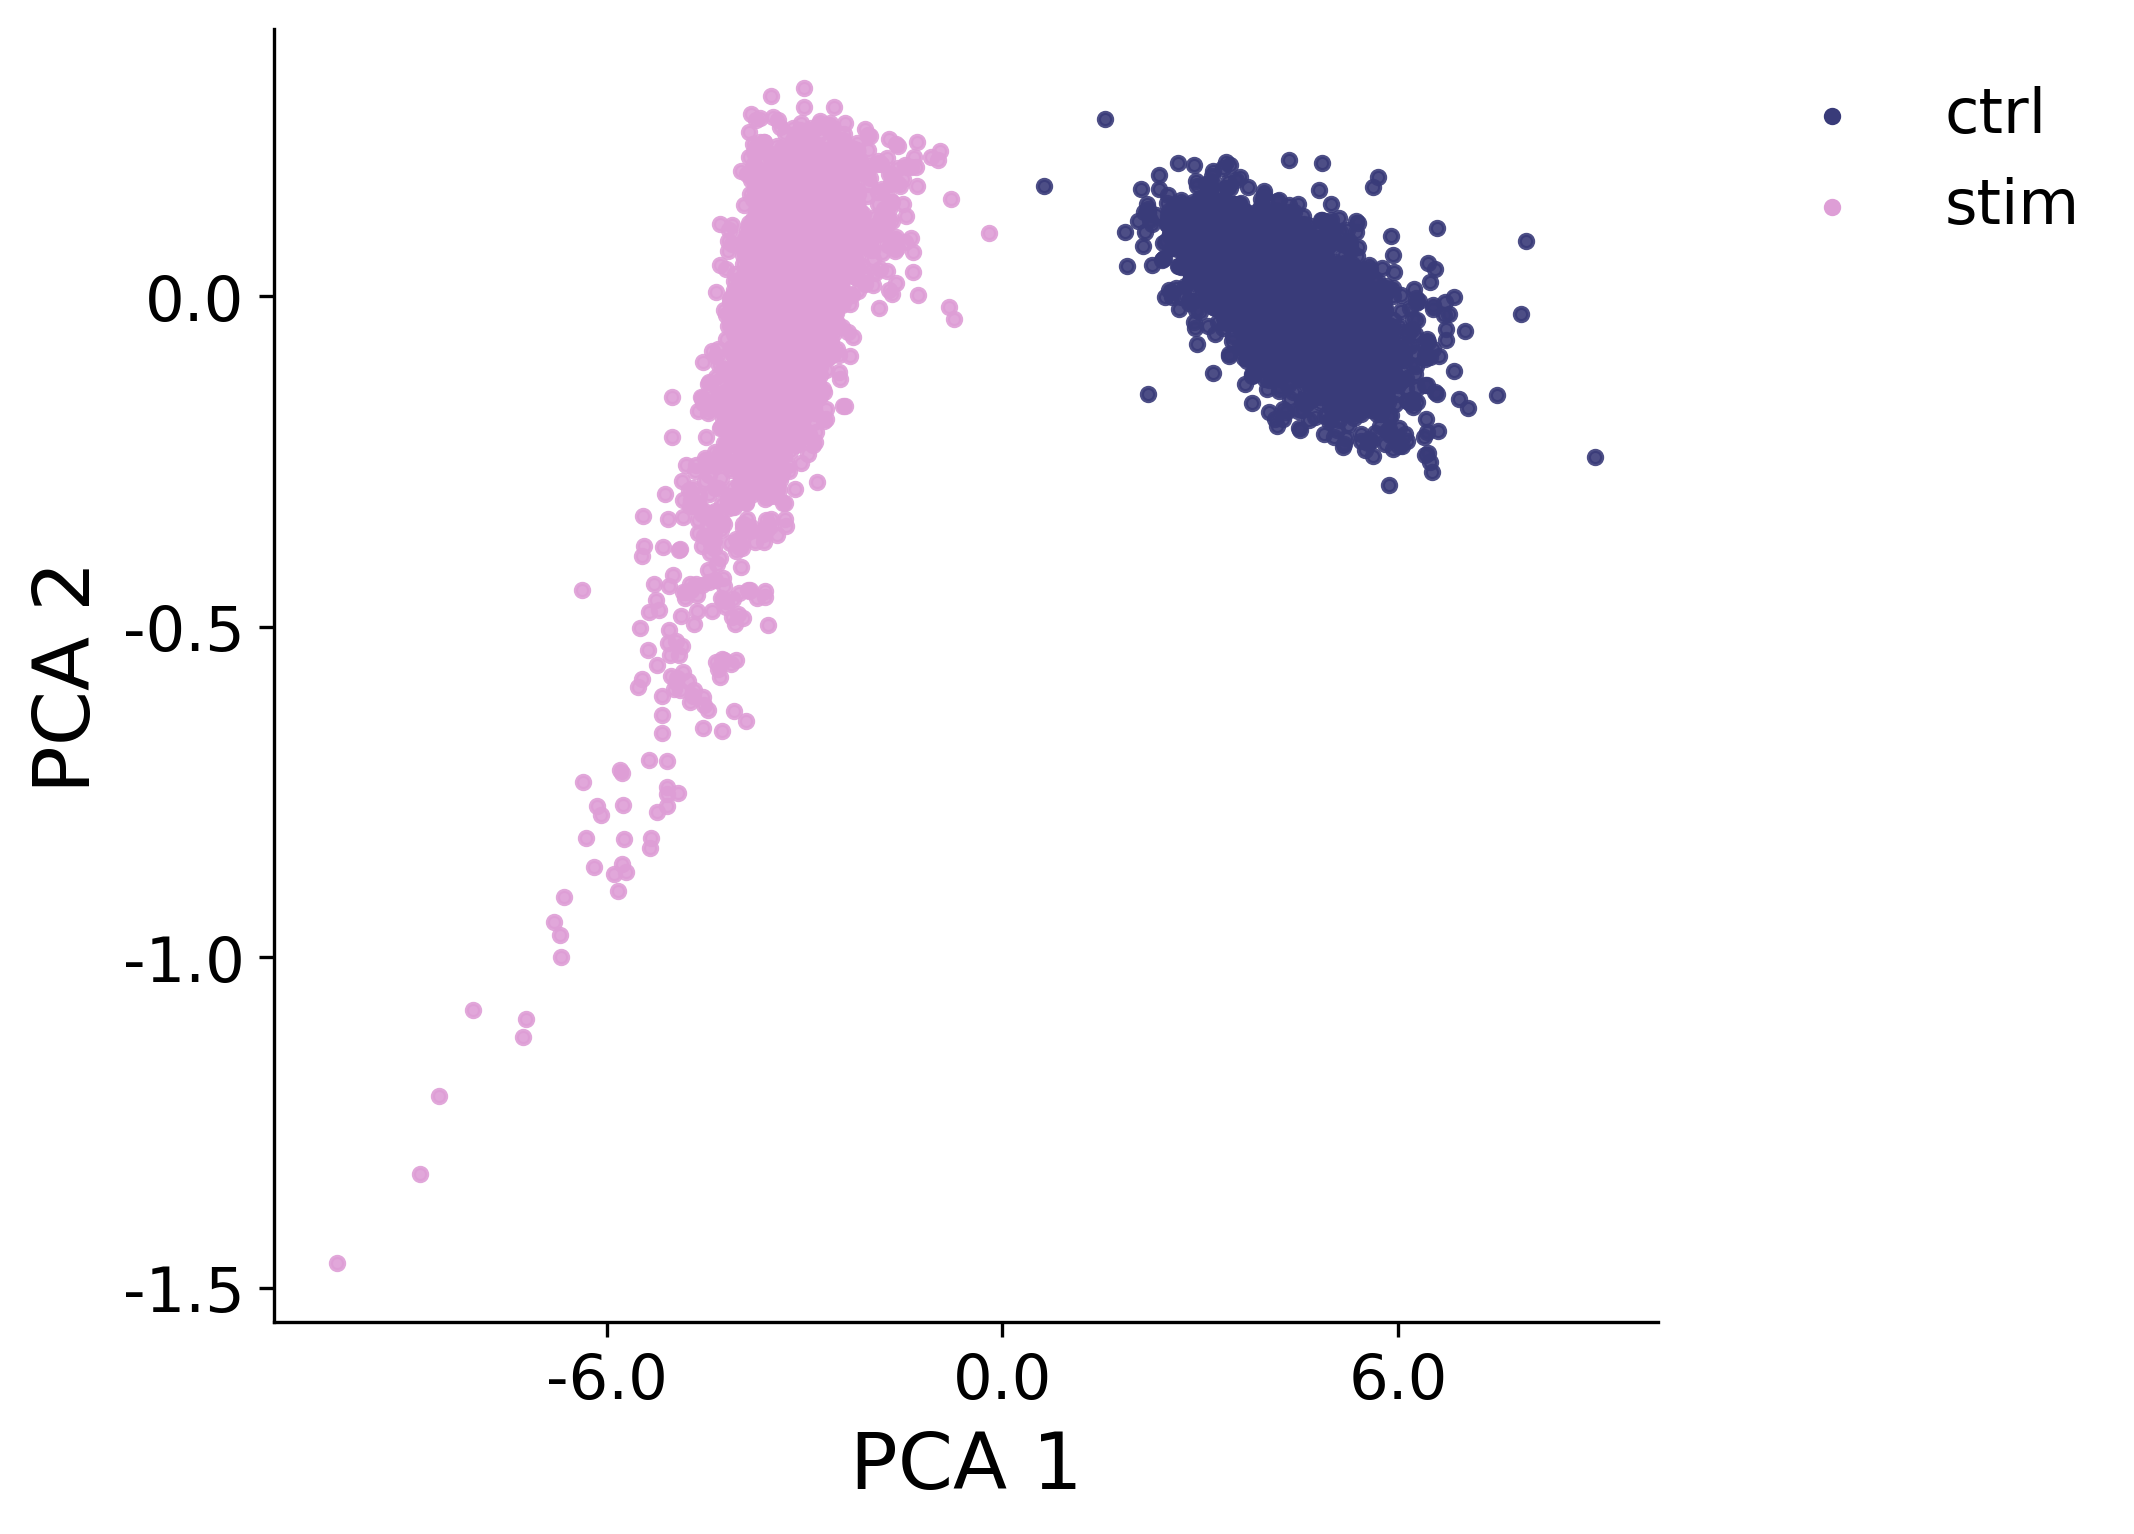

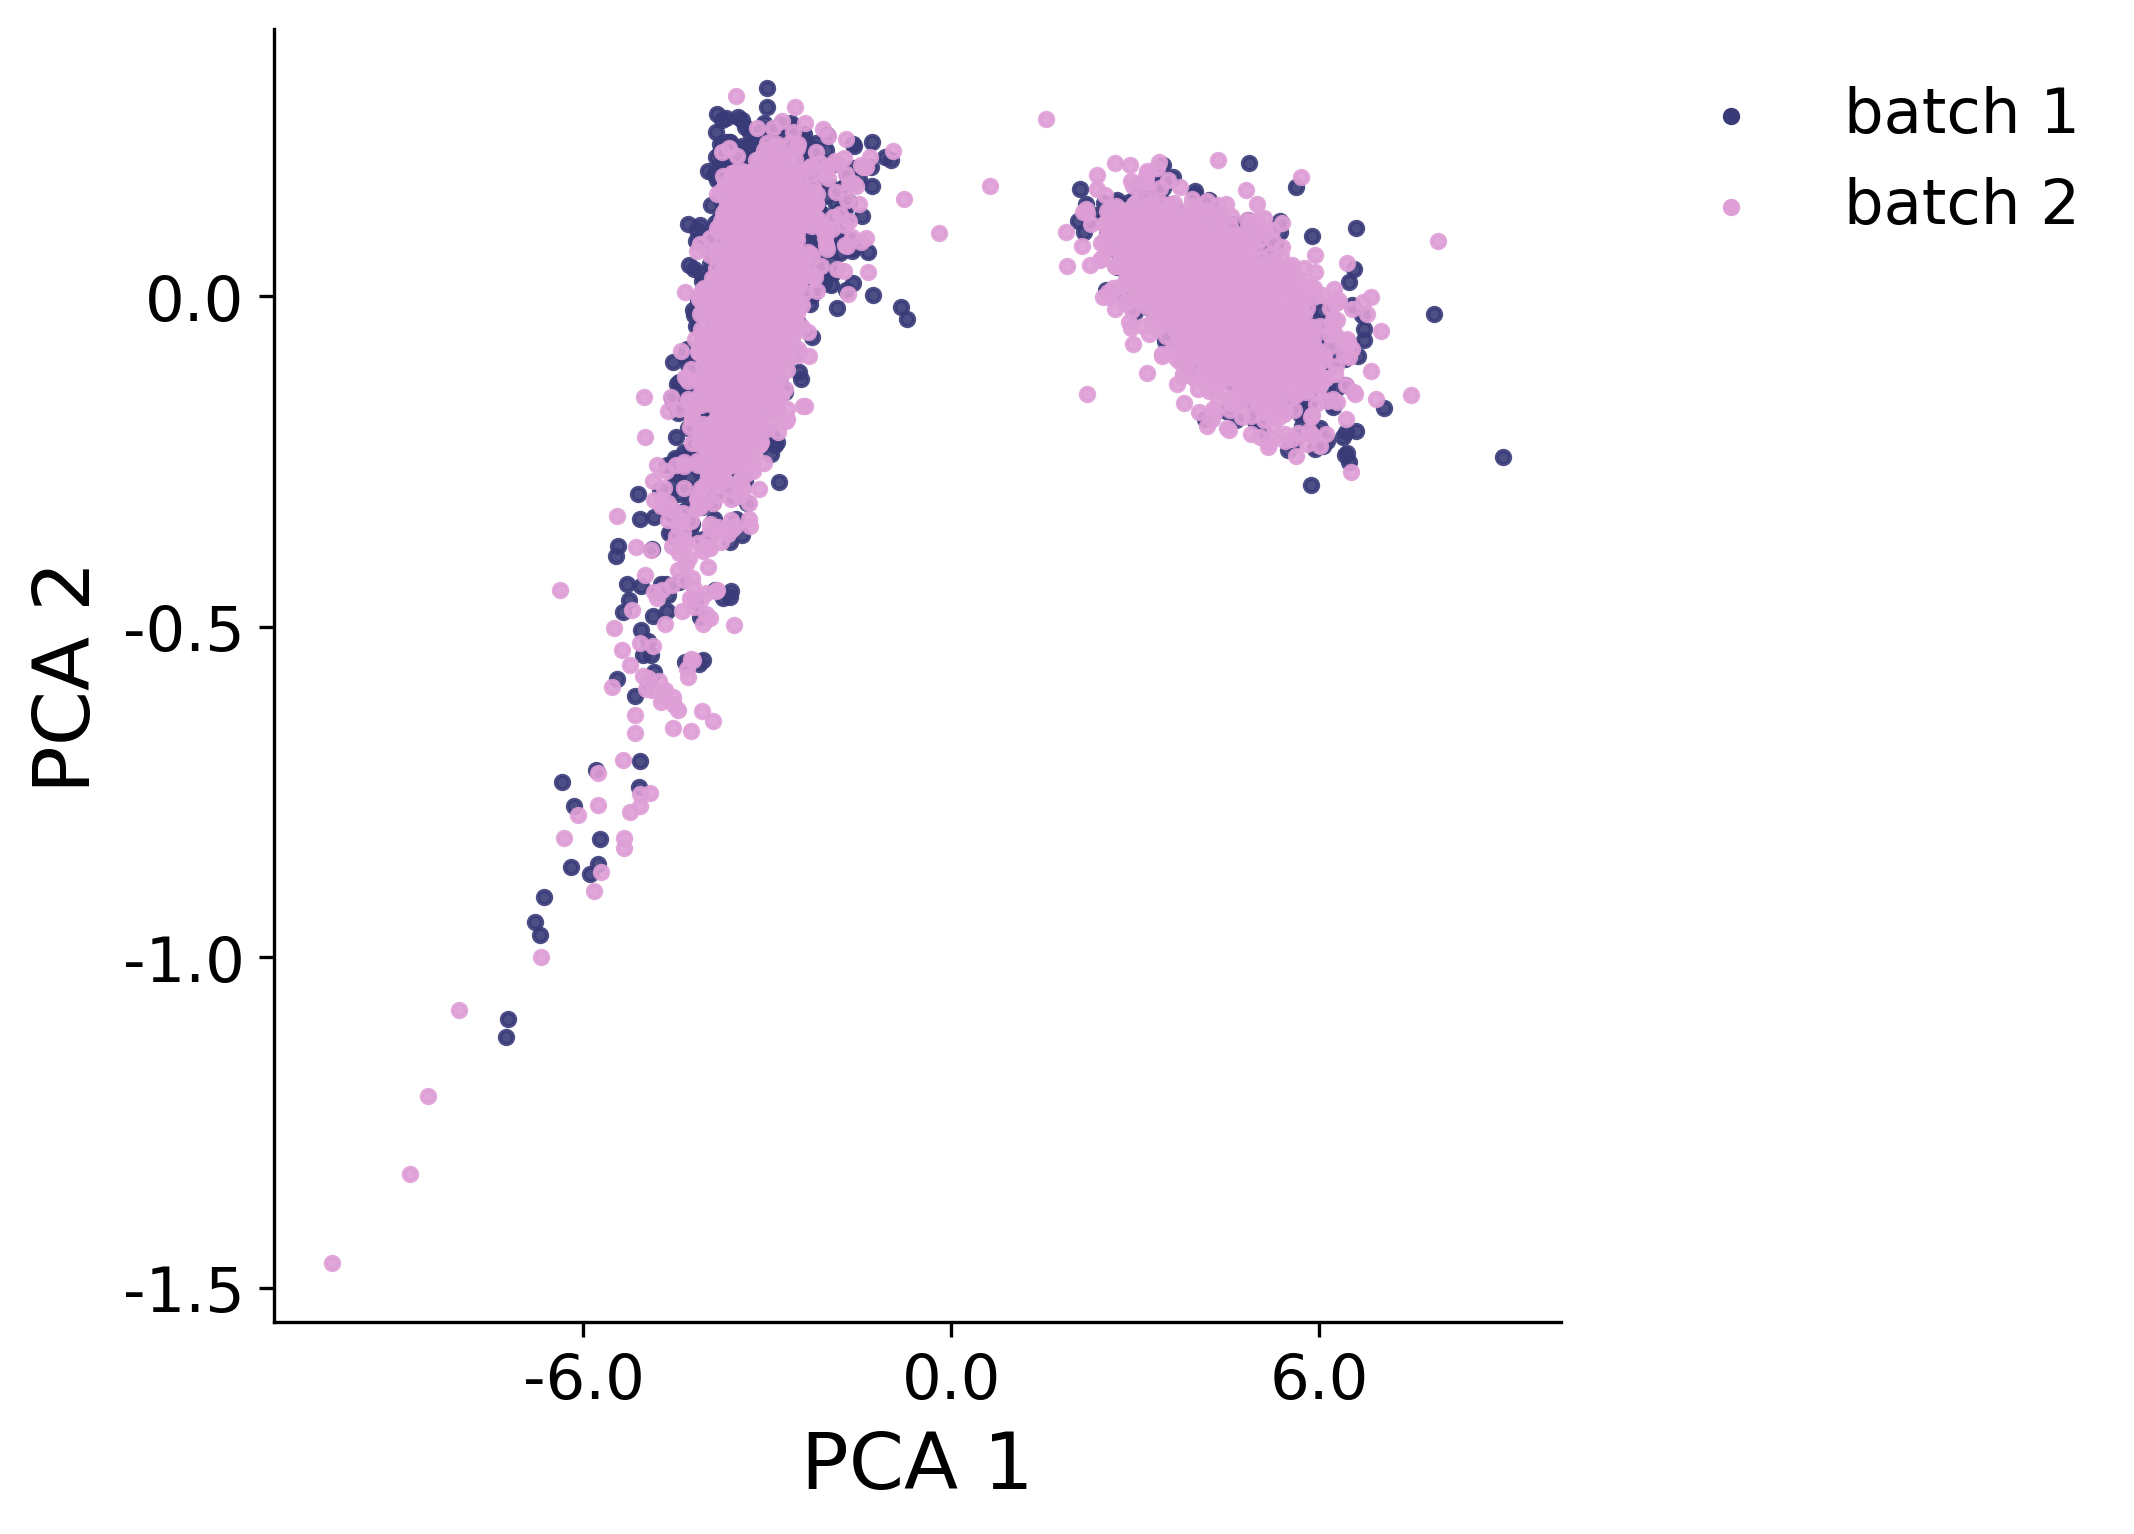

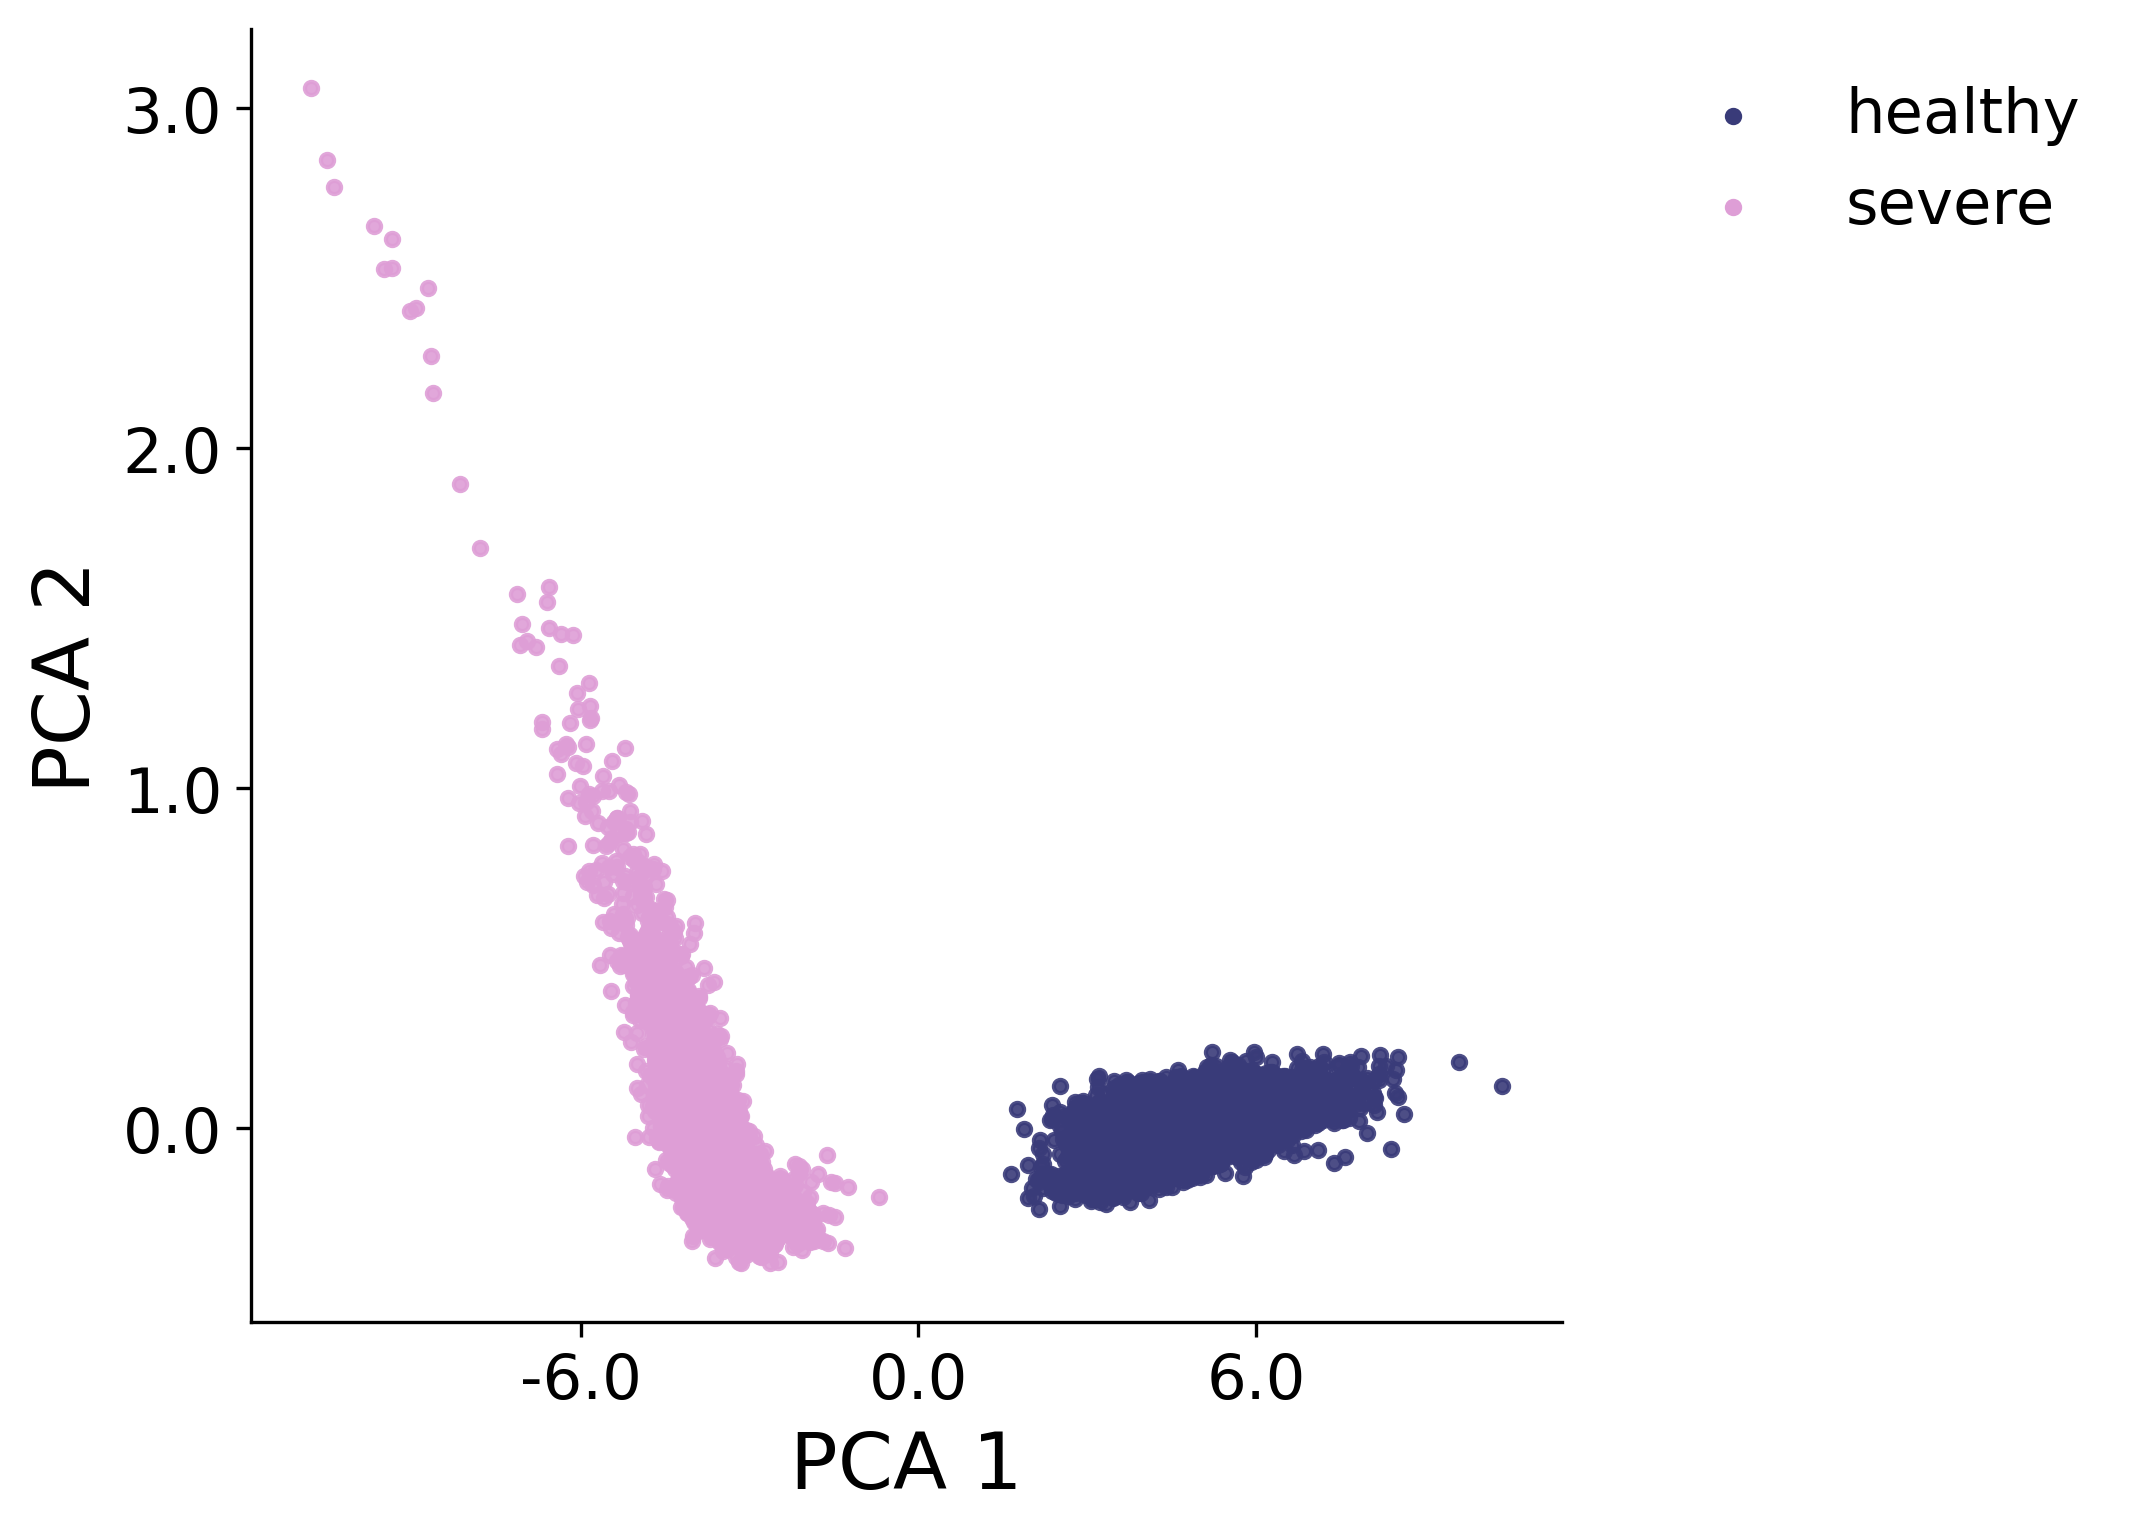

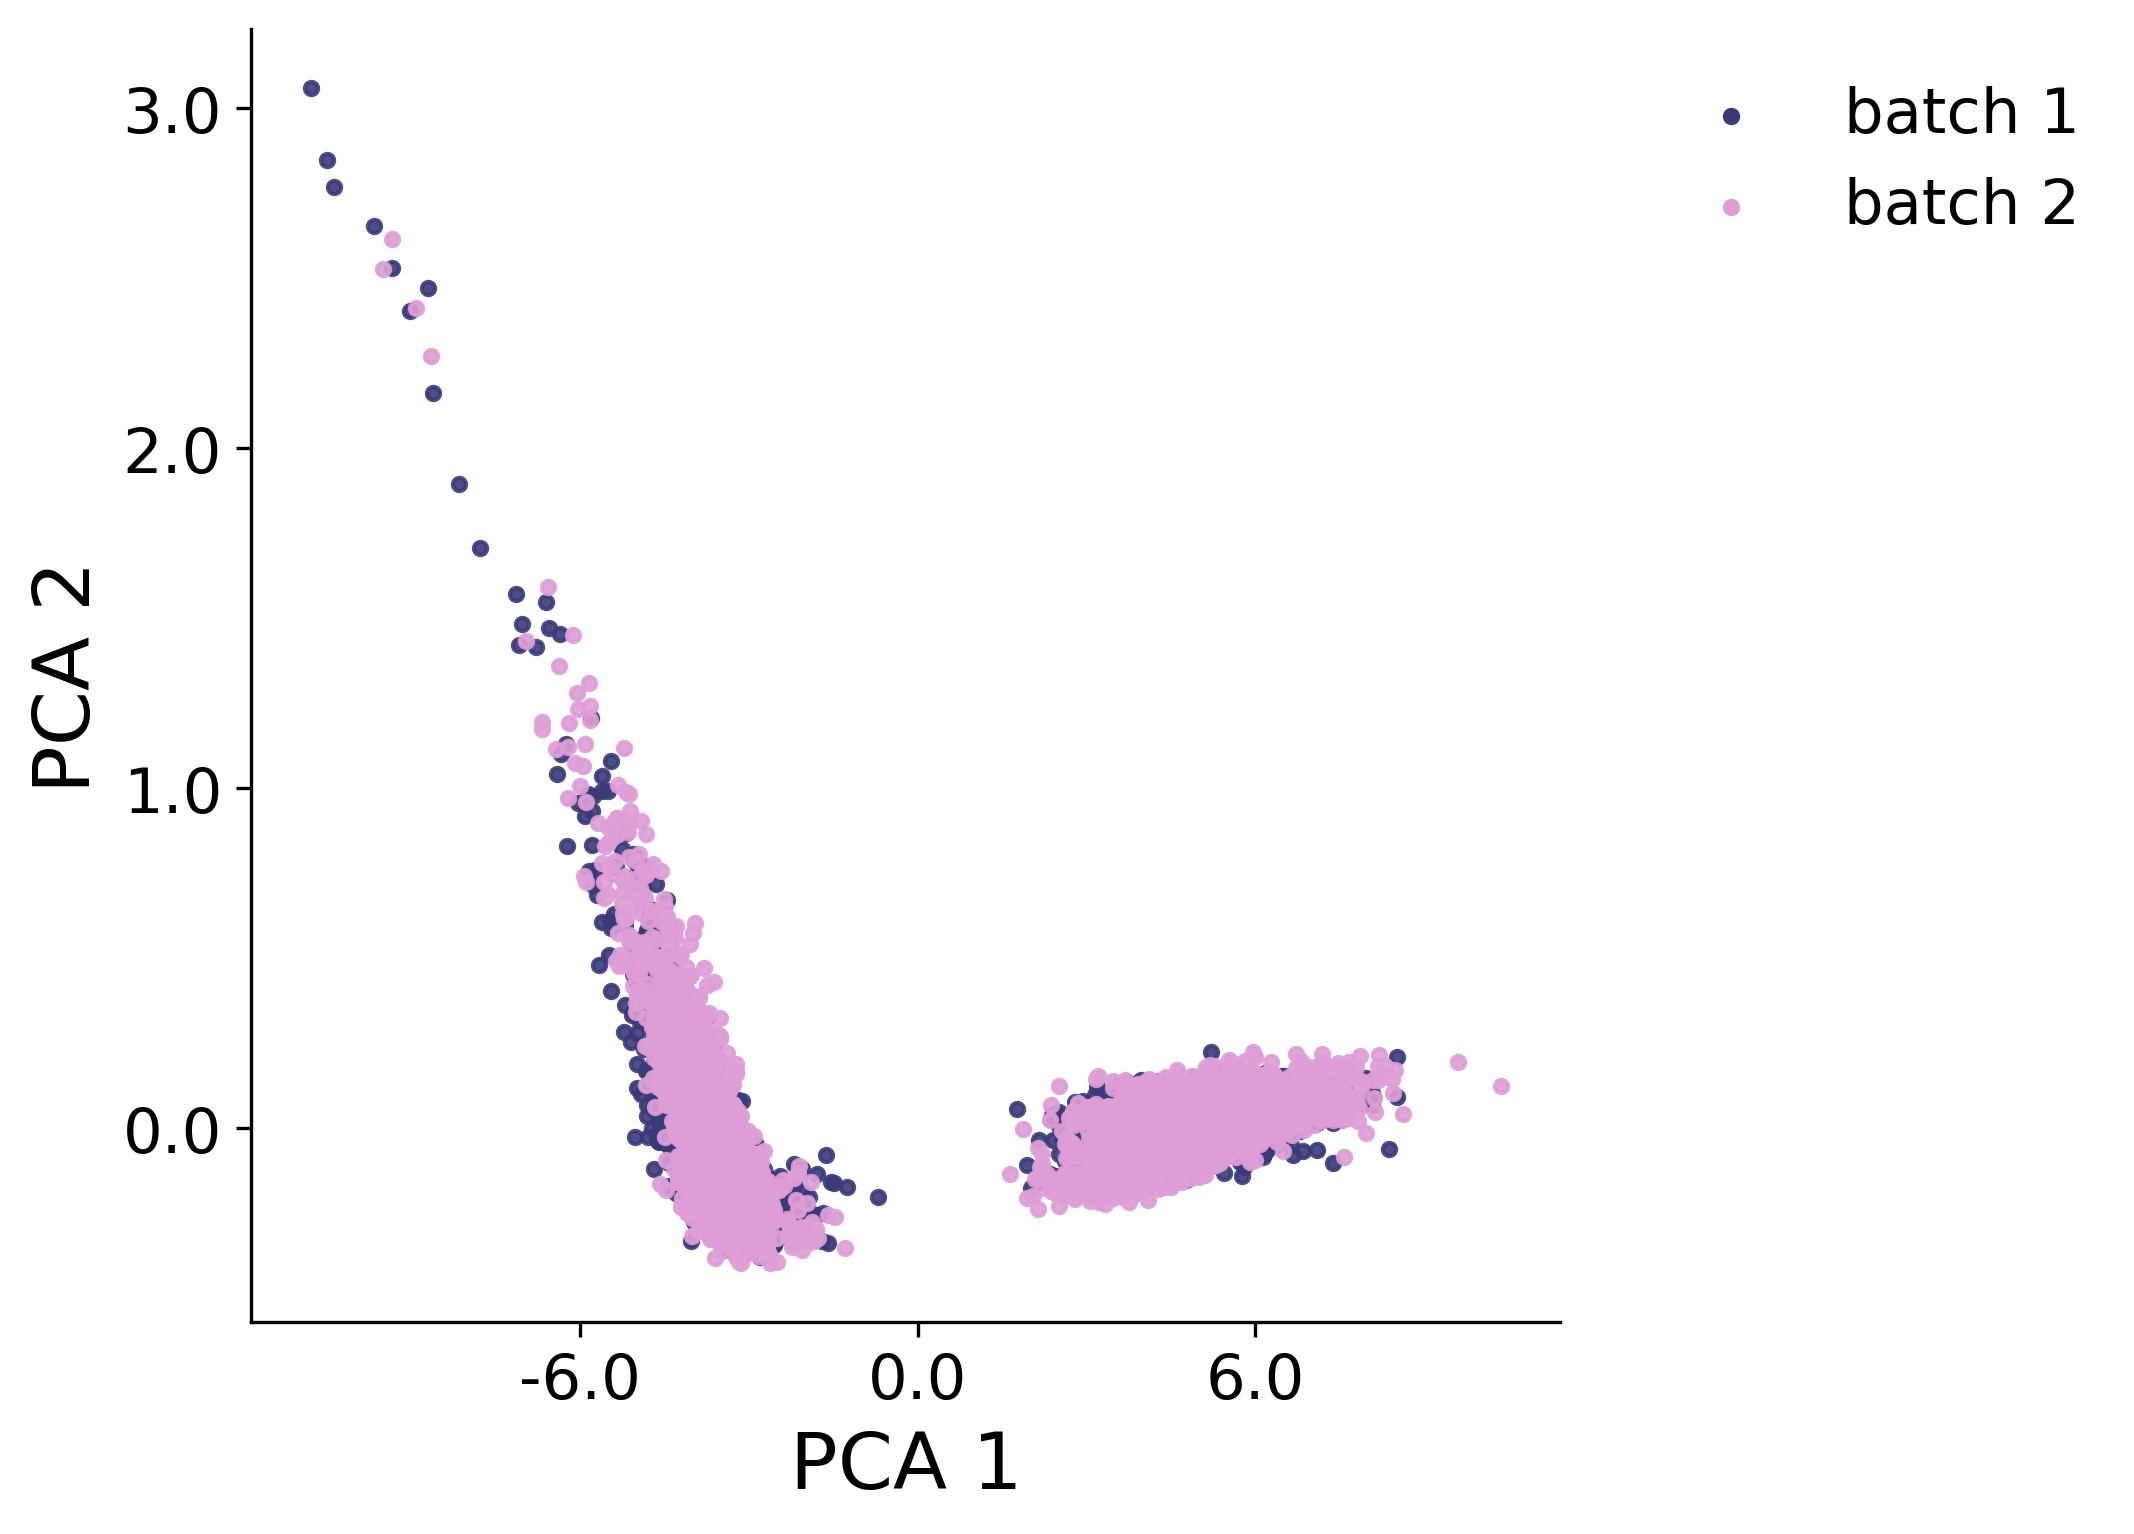

In [11]:
# UMAP
umap_op = UMAP(min_dist = 0.1, random_state = 0)
pca_op = PCA(n_components = 2)
z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
z_ds_umap = []
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[0] for z_d in z_ds], axis = 0)))
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[1] for z_d in z_ds], axis = 0)))

comment = f'results_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}/'
if not os.path.exists(result_dir + comment):
    os.makedirs(result_dir + comment)

batch_annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]])
batch_annos = np.where(batch_annos == 0, "batch 1", "batch 2")
utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (10,5), save = result_dir + comment+"common_dims_annos.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "separate", axis_label = "UMAP", figsize = (10,10), save = result_dir + comment+"common_dims_annos_separate.png")

utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_batches.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_cond1.png")

utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_cond1.png")
utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_batches.png")

utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_cond1.png")
utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_batches.png")


In [ ]:
!pip install scib_metrics

In [14]:
!pip install scipy

In [22]:
data = z_cs_umap  # UMAP embeddings
batch_labels = np.array([0 if b == "batch 1" else 1 for b in batch_annos])  # Encode batch labels
k = 30  # Choose number of neighbors

kbet_rejection_rate = kBET(data, batch_labels, k=k)
print(f"kBET rejection rate: {kbet_rejection_rate}")


kBET rejection rate: 0.1861368048418408


## Key gene extraction

The condition-associated gene scores can be extracted with `model.extract_gene_scores()`. The function returns a list with length equal to the total number of condition types. The $i$th element is the scores of genes (a `np.array`) under that condition type, the order of the scores matches the input genes.

In [ ]:
gene_scores = model.extract_gene_scores()
# the scores of 500 genes for condition type 1
print(gene_scores[0])
# the scores of 500 genes for condition type 2
print(gene_scores[1])


[1.63669419e-02 9.14421678e-03 1.03906989e-02 2.44847834e-02
 1.10281147e-02 5.04428595e-02 1.99805293e-02 2.87926253e-02
 2.26134062e-02 1.68385115e-02 1.64539106e-02 1.54288597e-02
 1.02815181e-02 1.06106382e-02 1.03216600e-02 2.21145283e-02
 1.20886862e-02 2.03598756e-02 9.06910188e-03 1.94463022e-02
 1.00129182e-02 2.09469944e-02 1.98464487e-02 1.67217739e-02
 9.54557024e-03 1.64563600e-02 1.14200022e-02 1.05871251e-02
 1.11636473e-02 1.32796932e-02 1.70270558e-02 2.98575647e-02
 1.59699973e-02 1.27448607e-02 9.04416014e-03 9.79706272e-03
 9.50883888e-03 3.32097337e-02 1.66252516e-02 1.65118147e-02
 1.34429010e-02 1.88532658e-02 1.07760923e-02 1.86592601e-02
 1.01714404e-02 2.33502220e-02 2.26591676e-02 1.37888743e-02
 1.82681791e-02 1.05414847e-02 1.22234732e-01 1.70774072e-01
 1.29416421e-01 6.95167482e-02 6.00959137e-02 1.07012443e-01
 6.50875494e-02 8.51563737e-02 5.50793707e-02 2.30056405e-01
 9.14855376e-02 5.90917945e-01 1.05939798e-01 5.47770932e-02
 2.53401399e-01 4.810522

## Prediction
Predict the count of the data under a different condition (and even remove the batch effect) with `model.predic_counts`.
* `predict_dataset` takes as input a scDisInFact dataset that user wish to perform prediction on.
* `predict_conds` take as input a list of predicting condition groups under each condition type.
* `predict_batch` take as input a value of the batch that the predicted count should be matched to.



Given the test matrix under `(stim, severe, batch 1)`, and we wish to predict the corresponding count matrix under `(ctrl, healthy, batch 0)`. We need to run

In [ ]:
input_idx = ((meta_cells["condition 1"] == "stim") & (meta_cells["condition 2"] == "severe") & (meta_cells["batch"] == 1)).values
counts_input = counts[input_idx,:].toarray()
meta_input = meta_cells.loc[input_idx,:]

counts_predict = model.predict_counts(input_counts = counts_input, meta_cells = meta_input, condition_keys = ["condition 1", "condition 2"],
                                      batch_key = "batch", predict_conds = ["ctrl", "healthy"], predict_batch = 0)


We can also denoise the count matrix under `(ctrl, healthy, batch 0)` by setting the `predict_conds` and `predict_batch` to be `None`

In [ ]:
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
counts_test = counts[test_idx,:].toarray()
meta_test = meta_cells.loc[test_idx,:]

counts_test_denoised = model.predict_counts(input_counts = counts_test, meta_cells = meta_test, condition_keys = ["condition 1", "condition 2"],
                                            batch_key = "batch", predict_conds = None, predict_batch = None)

Visualize the predicted counts and the denoised test count. Since condition and batch are aligned between predicted and test count, the gene expression should be also aligned

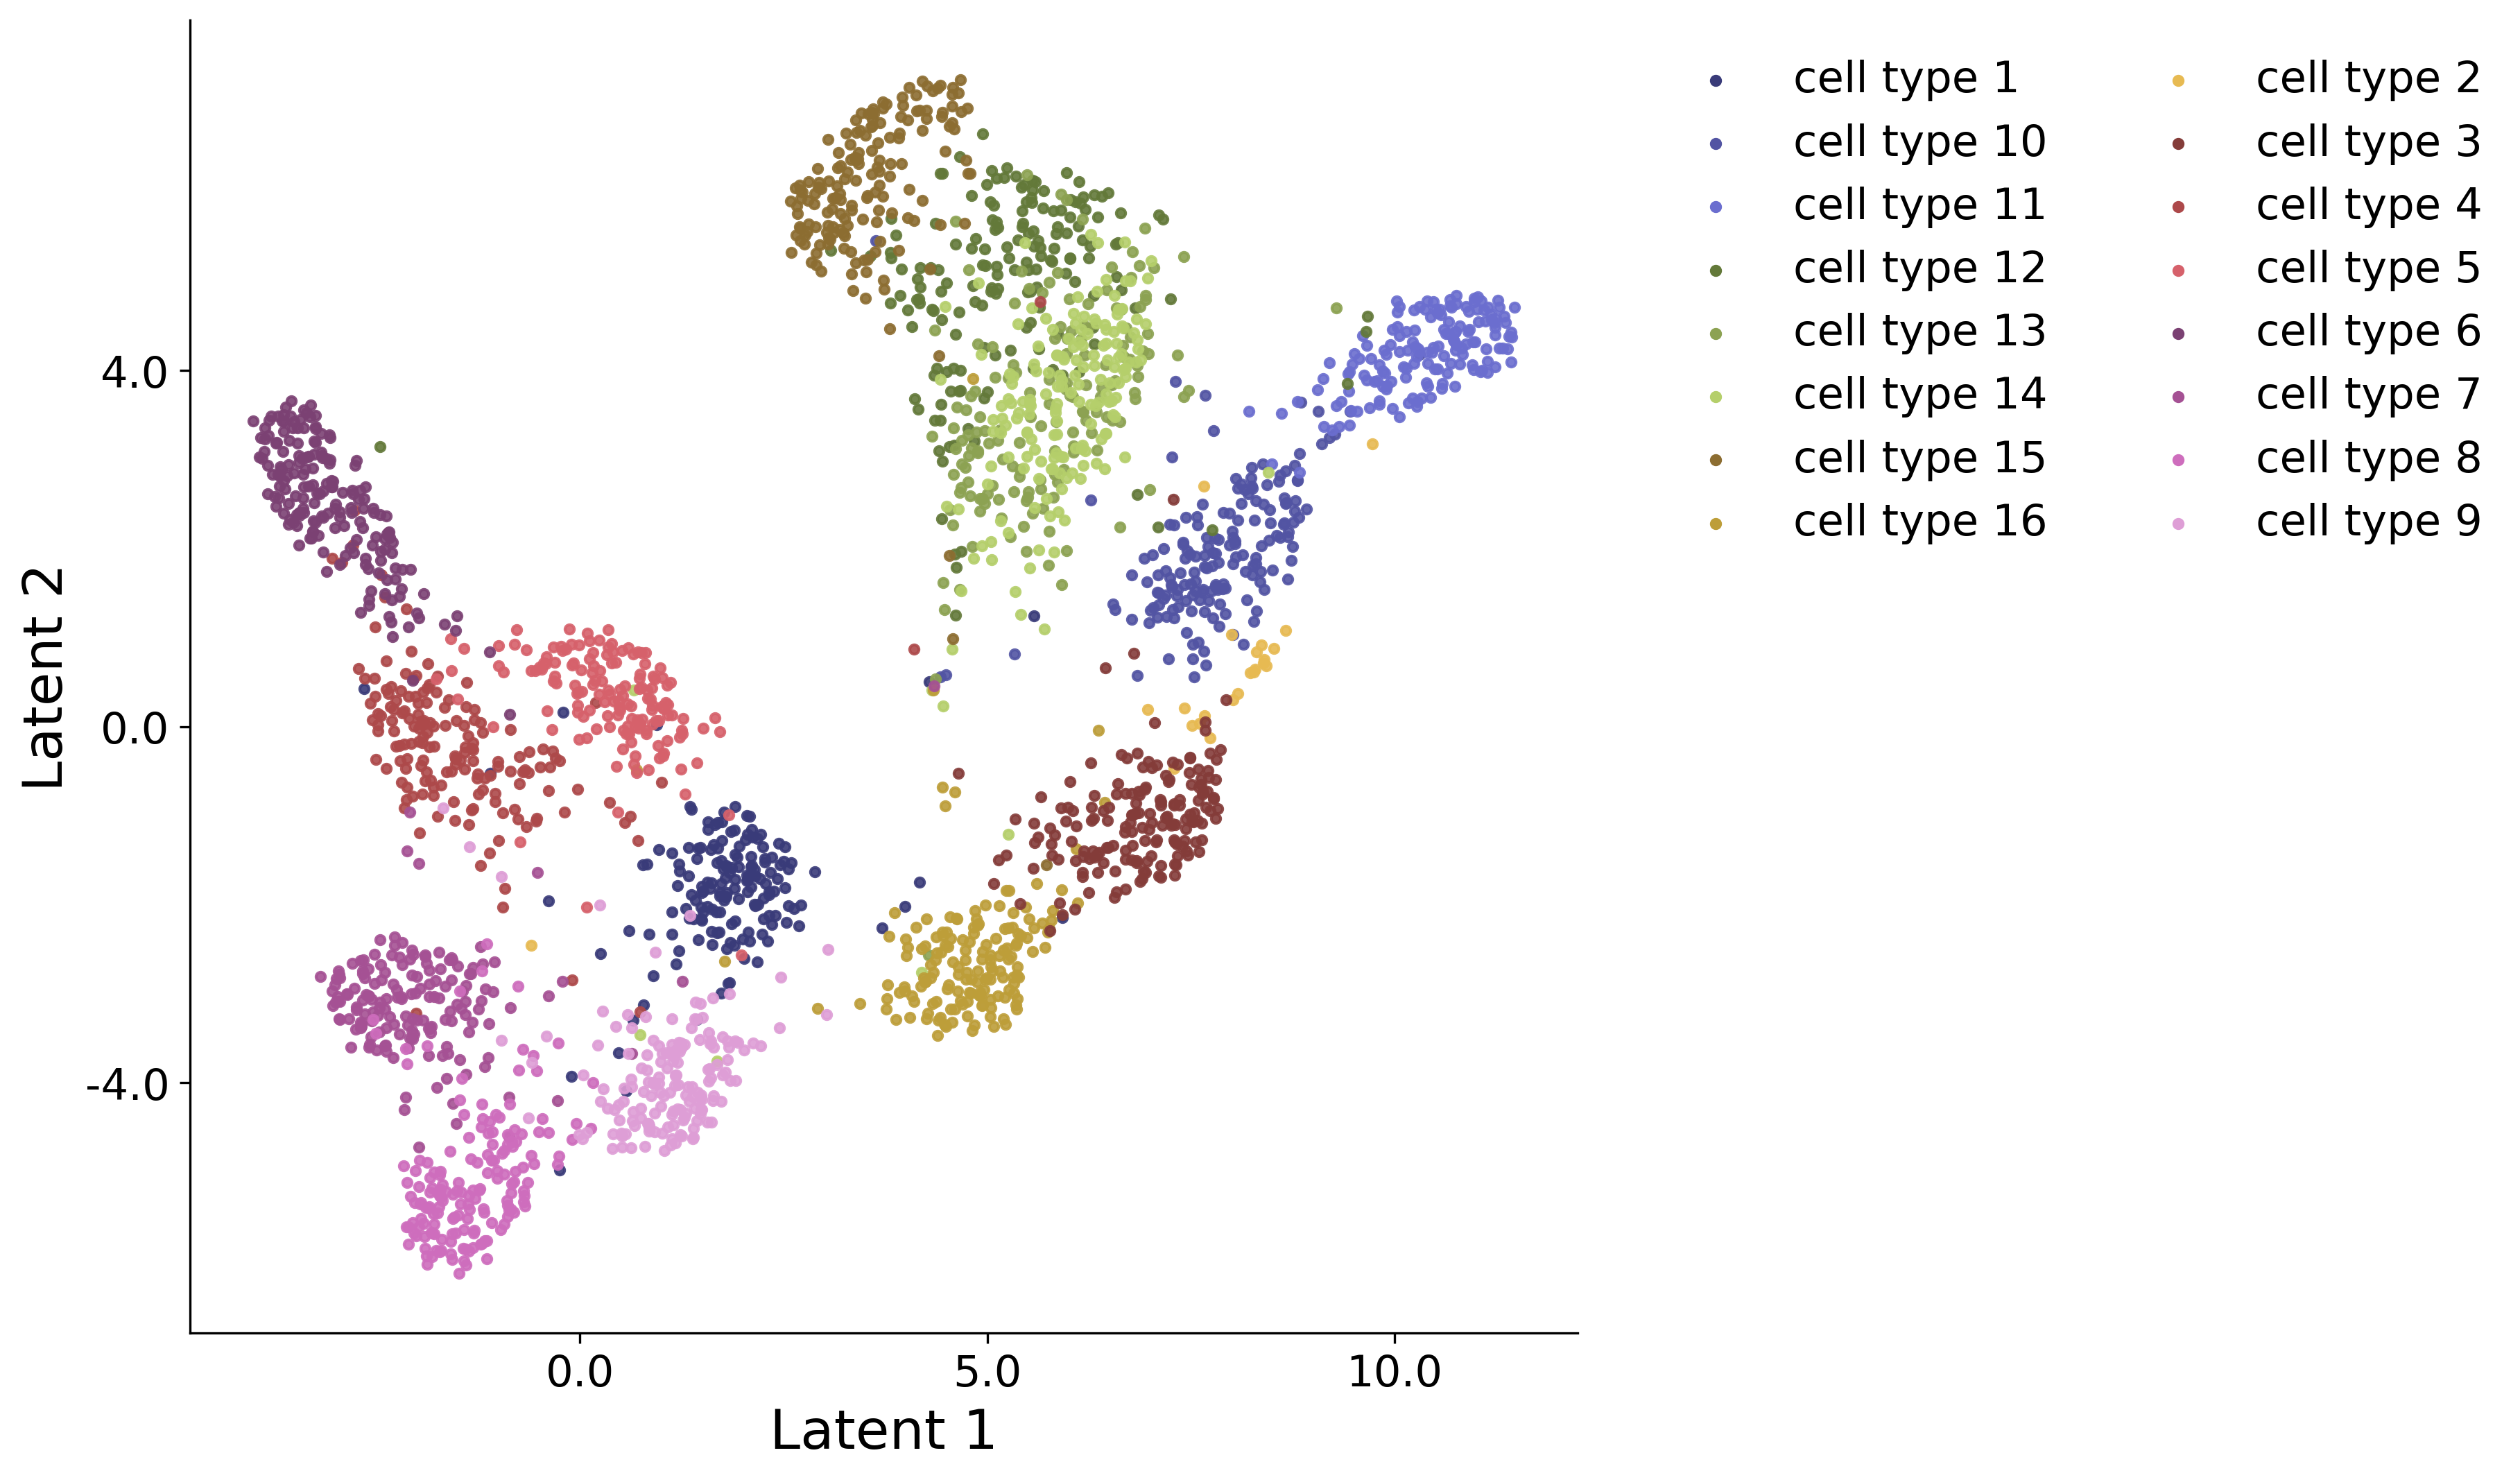

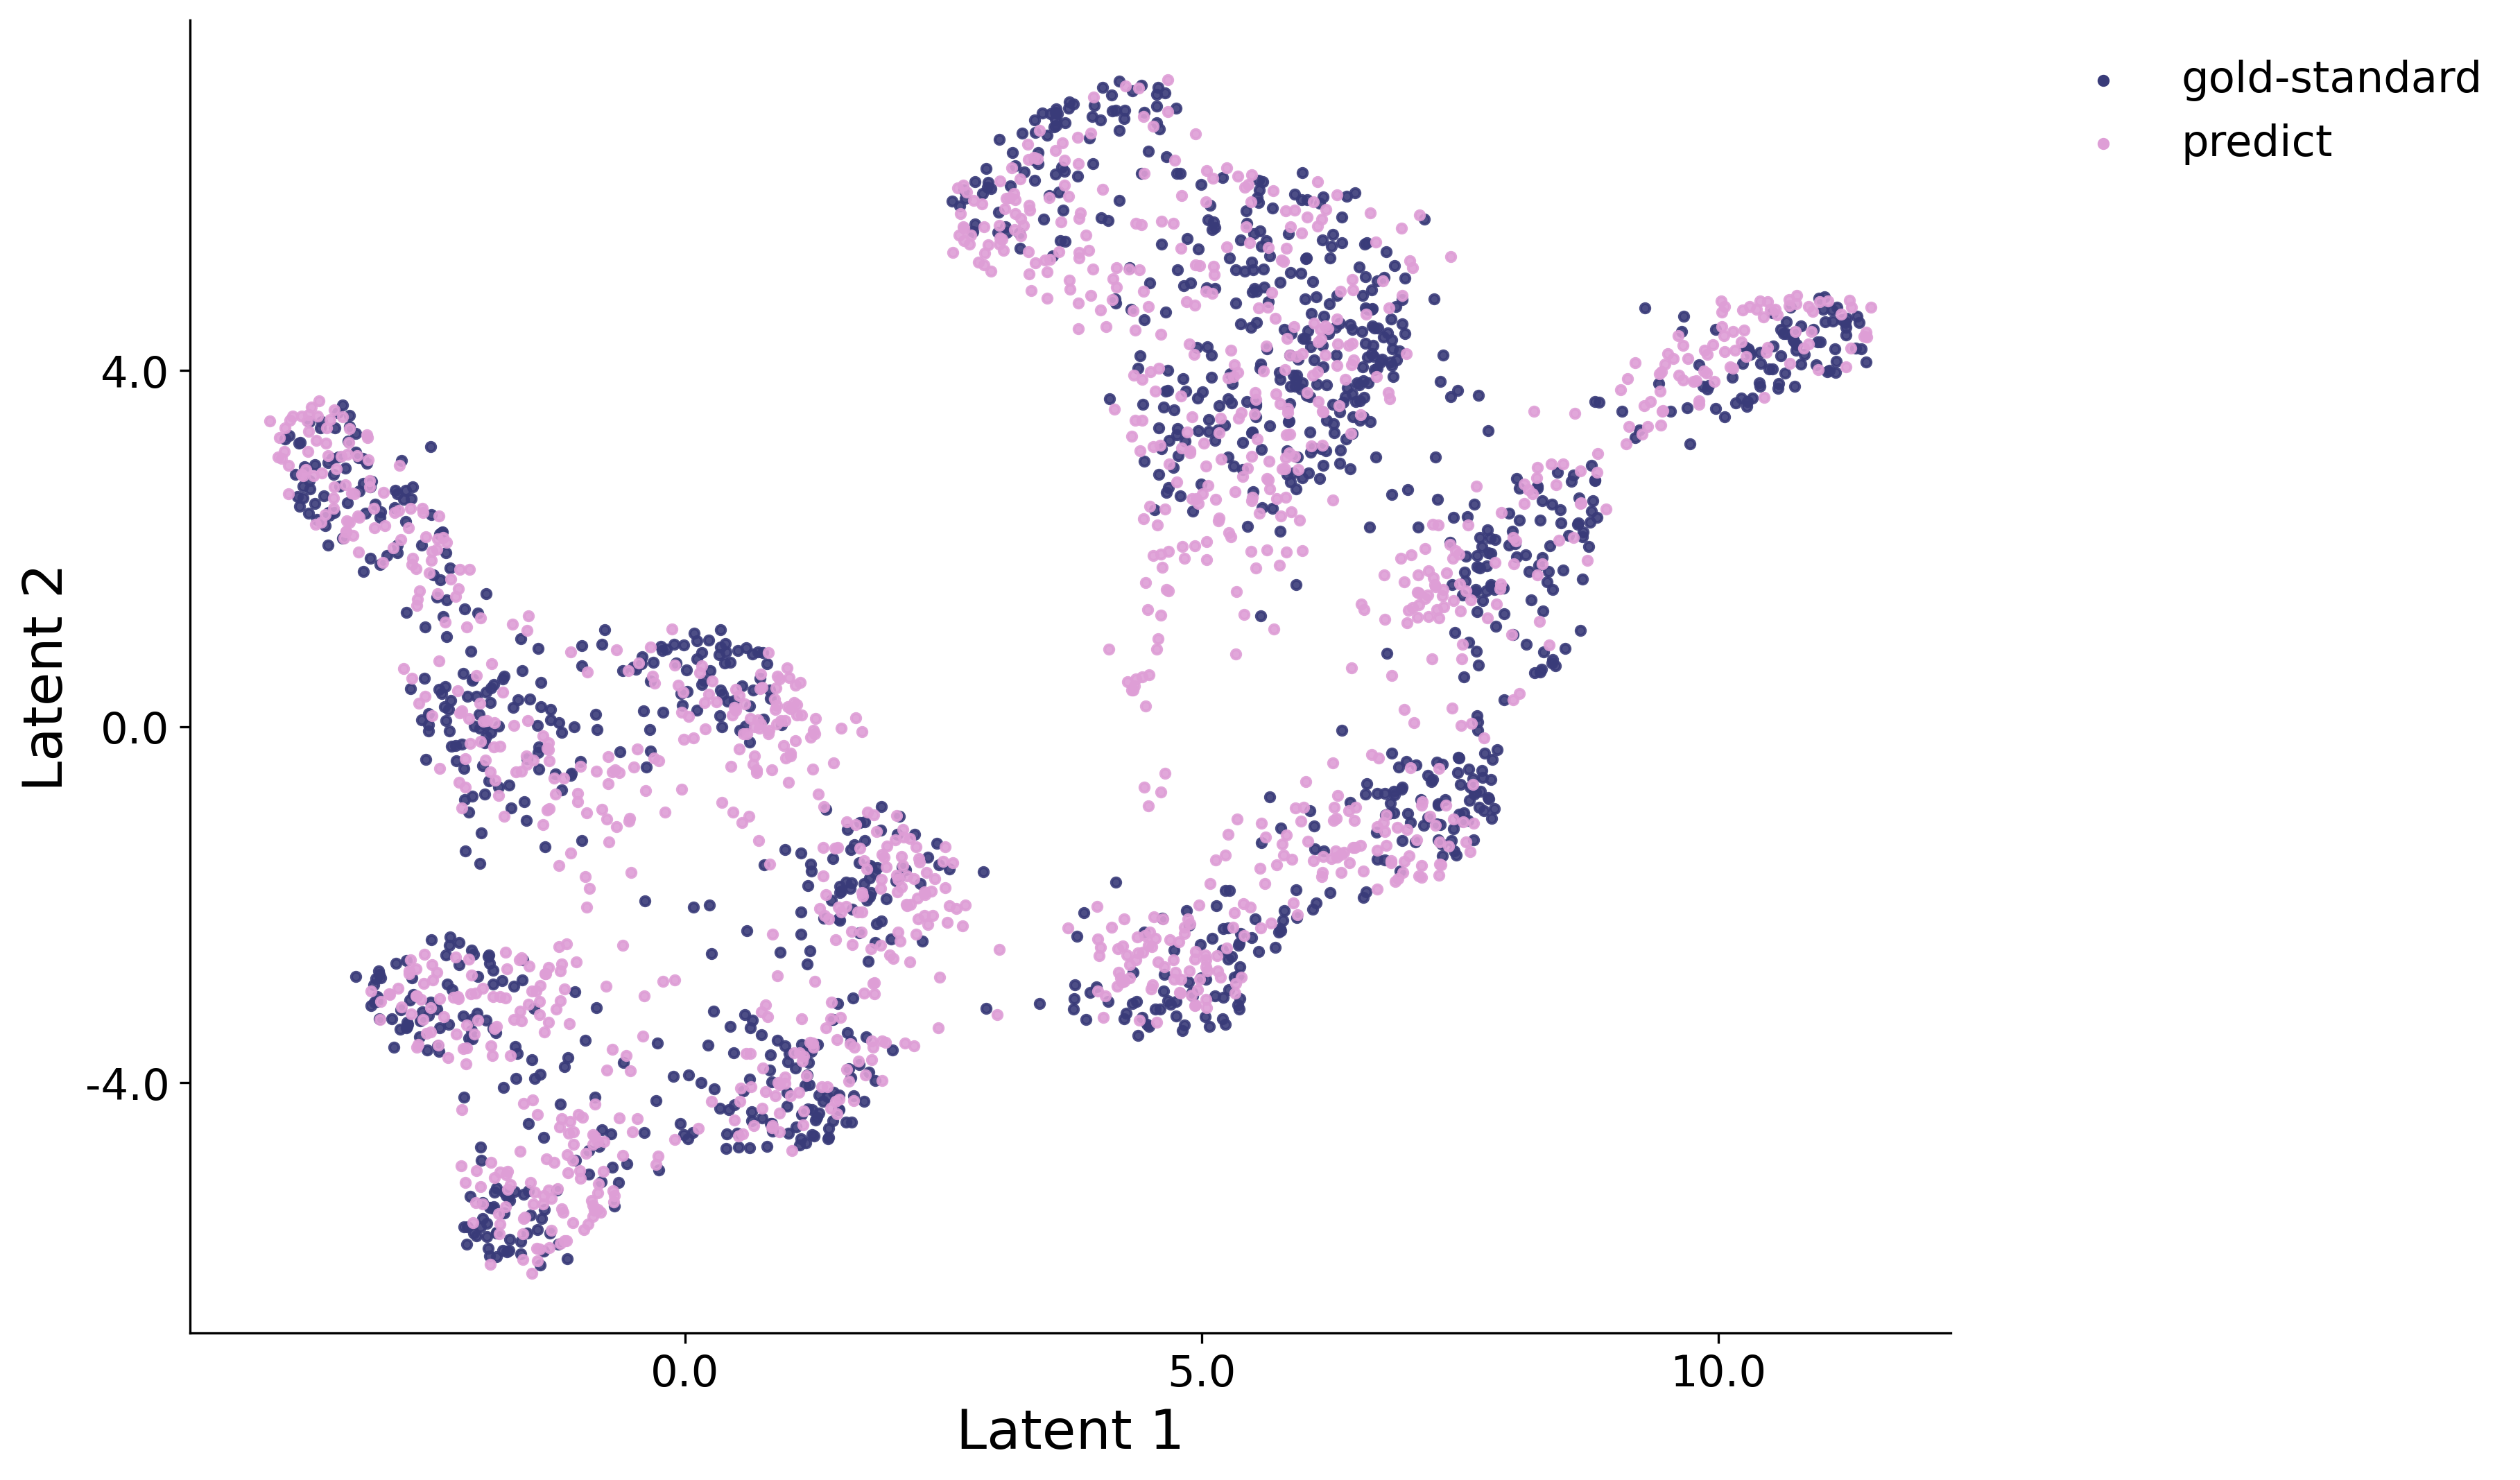

In [ ]:
counts_predict_norm = counts_predict/(np.sum(counts_predict, axis = 1, keepdims = True) + 1e-6) * 100
counts_predict_norm = np.log1p(counts_predict_norm)
counts_test_norm = counts_test_denoised/(np.sum(counts_test_denoised, axis = 1, keepdims = True) + 1e-6) * 100
counts_test_norm = np.log1p(counts_test_norm)
# plot umap
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0)
x_umap_scdisinfact = umap_op.fit_transform(np.concatenate([counts_predict_norm, counts_test_norm], axis = 0))

utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "annos", save = result_dir + comment + "predict_batches.png", figsize = (12,7))
utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "batches", save = result_dir + comment + "predict_batches.png", figsize = (12,7))